In [ ]:
!pip install lcdb
!pip install openml
!pip install func_timeout

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 68.2 MB 157 kB/s 
  Created wheel for lcdb: filename=lcdb-0.1.0-py3-none-any.whl size=71747350 sha256=8287e5e6f855505702dafb2db2e1018efe2e87fab17db246e36ce1dee9fcd9a1
  Stored in directory: /root/.cache/pip/wheels/11/53/1b/037b6b8a1f0604a5038b017f003c42b0f15f4ee933f00c06fe
Successfully built lcdb
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 140 kB 16.4 MB/s 
     |████████████████████████████████| 76 kB 6.0 MB/s 
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11732 sha256=71ff482f316829bc078f6c5ded6f70e9bfdf682ba510800bad2595abf497021b
  Stored in directory: /root/.cache/pip/wheels/a2/de/68/bf3972de3ecb31e32bef59a7f4c75f0687a3674c476b347c14
Successfully built liac-arff
Looking in indexes: https://pypi.org/simple, https://us-py

# DONE

1. Play around with openml and lcdb (cell 2 & 3)
2. Check consistency of df and decide how to predict:

To make it easier for numpy we take the first $n$ most common train sizes as starting input of learning curve. We also decide to predict at a common far spot ($2048$) problem is that for some learners and df it takes more data to complete learning (or less) and we miss out a bunch of datasets as we filter out the ones without those training points

3. Implement MDS and other baselines (simple and majority, all in cell 7)
4. With this method it shows that MDS is actually pretty good
5. Implement first try of competition style which was wrong. It was done as follows:

Take a random learner from dataframe, it competes against a random other learner. The winner competes against another random learner. This repeats until we get the overall winner.

6. Check the dataframe consistency and aggregate (cell 4):

The dataframe consists of 5 curves per learner (per dataset) these 5 curves are meant to be aggregated. This is done by taking the mean of the 5 curves. This also immediately fixes the issue of some curves having missing values. We could rerun everything on aggregated curves but I don't think this will change much as mostly curves from other datasets were chosen with my MDS algorithm. Instead it might be better to rerun with a new MDS algorithm that doesnt take a target train size.

7. Regularize dataframe:

Some learners in some datasets do not start at the same train size as the other learners. This is due to the fact that these learners are not able to function with less training data and need to start at a higher train size. A quick solution to this could be to remove those learners as there are not many, we do this for now. I think this completely removes QuadraticDiscriminantAnalysis and also removes sklearn.naive_bayes.MultinomialNB once (for some reason it only had 2 train_sizes in that one dataset). Another solution would be to somehow fill the missing train values, but with what?

8. Implement better MDS algo for $p_{sat}$ predictions.

To make it fast and efficient I want to use numpy to calculate learner1 vs learner2 for each dataset simultaneously for all combinations of learners. To do this we first pad all the missing learners (some learners aren't in some datasets, but not for long!) with np.nan's. With some broadcasting magic we can then get a whole numpy array of each possible competition for each dataset. (Also not really a big problem but np.mean or np.nanmean?, see comment in the relevant function).
ALSO, right now mds assumes each dataset has the given size_train points, which is fine as that is true for the first 5 points which should be enough

9. Turns our it wasn't $p_{sat}$ as I cannot assume the learning curves are complete, also $p_{sat}$ means something else, so now we go back to $p_{ref}$ formulation. We do this in the easiest method, by removing the datasets that don't contain $s_{ref}$

10. Fix subtract then average, implement leave one out in classifier

11. Implement binary tree classifier and random forest that predicts which of two input (part) learning curves will perform the best (when completed).

12. Mds scale before vs after



# TO DO

1. Decision tree do smart input features
- Make func for aveerror
- Try some of other columns given by lcdb

2. Implement mmf baseline


# MAYBE
1. Uncertainty of model for early stopping (uncertainty modeling). With less points its more uncertain so we want to do early stopping when the probability of l1 being worse than the baseline is above a threshold.

2. "We now consider the probability that some learner A will outperform learner
B at the highest available training size" - LCDB paper, 3.2 Learning Curve Crossing

3. Implement Jan competition style

For each dataset in the dataframe do the following. Pick $2$ random learners from the dataset and make them compete, the winner competes against another random learner from the dataset. This repeats until we only have one learner left. This overall winning learner (for that dataset) gets one point. \\
Then the learner with the most points is the best learner overall.

4. Implement better MDS algo for $p_{ref}$ predictions: If for the current curve $\forall i : s_i \neq s_{ref}$:
*   If for the current curve $∃i : s_i>s_{ref}$, interpolate between $p_{i-1}$ and $p_i$ (e.g. $\frac{1}{length}[p_{i}+p_{i-1}]$)
*   If not, $s_{ref} = p_{\max_i {s_i}}$, this is asuming the curve is done learning at it's final anchor point, so at any beyond that the same value would be returned
![idea](https://drive.google.com/uc?id=1pShmejELDMt-aBYgMUKwBNrXfuVf3ao7)

5. Fix MDS for train_size. FIXED with regularizedf

Right now mds assumes each dataset has the given size_train points, which is fine as that is true for the first 5 points which should be enough

# Note
Full tensorized etc. now assumes most things are [1,2,3,4,5,6,7,nan,nan,nan] not [1,2,3,nan,5,6,7,nan,nan,nan]

\\

Also, prediction isn;t efficient but it doesn't need to be? E.g. giving it 3 targets and saying no windows means it predicts 3*3 times as it makes a window for each target and predict from that window to each target.

# Imports

In [1]:
import random
from itertools import combinations

import lcdb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import openml
import pandas as pd
import torch
import time
from scipy.optimize import minimize
from scipy.optimize._lsq.least_squares import least_squares

In [ ]:
# Trying out openml
#metric = "predictive_accuracy"
#suite = openml.study.get_suite(99)
#evals = openml.evaluations.list_evaluations(
#    function=metric, tasks=[suite.tasks[2]], output_format="dataframe"
#)

In [2]:
# Trying out lcdb
curves = lcdb.get_all_curves()
aggCurves = curves.groupby(['openmlid', 'learner', 'size_train']).mean().reset_index()

"""
# Checking if there is consistent train_sizes
last = aggCurves.groupby(['openmlid', 'learner']).last().reset_index()
unique_train_size_learners = aggCurves.groupby(['openmlid', 'learner']).count().reset_index().groupby(['openmlid','size_train']).first().reset_index()
consistentIndex = unique_train_size_learners.groupby(['openmlid']).tail(1).index
inconsistent = unique_train_size_learners.drop(consistentIndex)

# For each dataset each learner has the same final size_train, sometimes up to 1 learner doesn't have some of the earlier size_train's
display(inconsistent)
"""

# We drop inconsistent train_size learners in their respective dataset where they are inconsistent
# A smarter regularization could be done but this is simpler for now
aggCurves['count'] = aggCurves.groupby(['openmlid','learner'])['size_train'].transform('count')
normCount = aggCurves.groupby(['openmlid'])['count'].transform(lambda x: x/np.max(x))
ind = np.array(normCount[normCount != 1].index)
aggCurves = aggCurves.drop(ind)

# This will show how many datasets have the given train_size (so not per learner, as every learner in the dataset has the same train_sizes. We thus check how many db have the train_size)
train_size_count = aggCurves.groupby(['openmlid','size_train']).first().reset_index().groupby(['size_train'])[['size_train']].count().rename(columns = {'size_train':'Count'})
display(train_size_count)
learners = aggCurves['learner'].unique()
for i, learner in enumerate(learners):
  if '.' in learner:
    learners[i] = learner[learner.rfind('.')+1:]
learners = list(learners)
# We see that the train sies 16, 23, 32, 45, 64 are in every dataet thus we can freely use those

,Count
size_train,
16,245
23,246
32,246
40,1
45,244
...,...
1048576,2
1482910,1
1486391,1


In [3]:
Slearners = ['SVCl','SVCp', 'SVCr', 'SVCs','xTrs','GrBo','rFor','LogR','PaAg', 'Perc', 'Ridg', 'SGD','Bern','MuNo', 'KNei', 'MLP', 'dTre', 'xTre','linD','QuaD']

90 percent of data?

# Plotting Functions

In [4]:
# Added xlabel input, might destroy some things?
def Boxplots(plots, ylabel = None, xlabel = None, hline = 'N', xrot = False, ylim = None, figsize = (1,1), col = ['black', 'red', 'blue', 'green'], legend_loc = 'upper right', title = None, means = False):
    plotlabels = list(plots.keys())
    w,h = *figsize,
    fig, ax = plt.subplots(figsize=(6.4*w, 4.8*h))
    if ylim:
      ax.set_ylim(*ylim)
    if ylabel:
      ax.set_ylabel(ylabel)
    if xlabel:
      ax.set_xlabel(xlabel)
    if hline != 'N':
      plt.axhline(hline,linestyle = '--')
    if title:
      fig.suptitle(title,y=1)

    n_dicts = len(plots)
    if type(plots[plotlabels[0]]) != dict:
      n_dicts = 1
    boxes = []
    for i in range(n_dicts):
      c = col[i]
      if n_dicts == 1:
        labels, data = [*zip(*plots.items())]
      else:
        labels, data = [*zip(*plots[plotlabels[i]].items())]
      data = [np.array(dat)[~np.isnan(np.array(dat))] for dat in data]
      pos = np.arange(0,len(labels))*n_dicts+1+i
      tempbox = ax.boxplot(data, positions=pos, showmeans = means,patch_artist=True,
                boxprops=dict(facecolor = 'white', color=c),
                capprops=dict(color=c),
                whiskerprops=dict(color=c),
                flierprops=dict(color=c, markeredgecolor=c)
                )
      boxes.append(tempbox)
    pos = np.arange(0,len(labels))*n_dicts+1+(n_dicts-1)/2
    ax.set_xticks(pos)
    if xrot:
      ax.set_xticklabels(labels,rotation = 45, ha = 'right')
    else:
      ax.set_xticklabels(labels)
    if n_dicts != 1:
      ax.legend([box["boxes"][0] for box in boxes], plotlabels, loc = legend_loc)
    plt.show()

def PlotHeatmap(plots,label = False, min = 0, max = 1, cmap = None):
    # If we dont put in a list and just want one plot
    if type(plots) == np.ndarray:
      n = 1
      fig, ax =plt.subplots(1,1, figsize = [6.4*2,4.8*2])
      sns.heatmap(plots, vmin = min, vmax = max, cmap = cmap)
      if label:
        ax.set_yticklabels(Slearners, rotation = 0)
        ax.set_xticklabels(Slearners,rotation = 90)
    else:
      labels, data = [*zip(*plots.items())]
      n = len(data)

    
      # The smallest square in which to fit all the subplots
      square = int(np.ceil(np.sqrt(n)))
      # Since we can make a rectangle instead of a square we check the minimum rows we need
      rows = int(np.ceil(n/square))

      # Default figsize is [6.4,4.8] so I just double the width
      fig, ax =plt.subplots(rows,square, figsize = [6.4*(square+1),4.8*(rows+1)])
      i = 0
      for axis in ax.flatten():
        if i < n:
          sns.heatmap(data[i], ax=axis, vmin = min, vmax = max, cmap = cmap)
          axis.set_title(labels[i])
          if label:
            axis.set_yticklabels(Slearners, rotation = 0)
            axis.set_xticklabels(Slearners,rotation = 90)
        else:
          axis.set_axis_off()
        i += 1
      # set the spacing between subplots
      #fig.subplots_adjust(wspace=0.4,hspace=0.4)
      fig.show()

def HeatmapBoxPlot(plots, ylabel = None, hline = 'N', ylim = None, label = False, min = 0, max = 1, cmap = None, title = None):
    nplots = len(plots)
    fig,ax = plt.subplots(nplots,2, figsize = [6.4*(2+1),4.8*(nplots+1)])
    axis = ax.flatten()
    labels, data = [*zip(*plots.items())]
    if title:
      fig.suptitle(title,y=0.9)
    for i in range(nplots):
      axis[2*i].set_title(labels[i])
      axis[2*i+1].set_title(labels[i])
      sns.heatmap(data[i], cmap = cmap, vmin = min, vmax = max, ax = axis[2*i])
      if label:
        axis[2*i].set_yticklabels(Slearners, rotation = 0)
        axis[2*i].set_xticklabels(Slearners,rotation = 90)
      axis[2*i+1].boxplot(data[i][~np.isnan(data[i])].ravel())
      if ylim:
        axis[2*i+1].set_ylim(*ylim)
      if ylabel:
        axis[2*i+1].set_ylabel(ylabel)
      if hline != 'N':
        axis[2*i+1].axhline(hline,linestyle = '--')
    
    fig.show()

def Compare(algos, truth_reference, ylabel = 'Difference in Average Absolute Error', hline = 0, ylim = None, label = False, min = -1, max = 1, cmap = 'seismic',title = None):
    labels, data = [*zip(*algos.items())]
    shape = truth_reference.shape
    d = []
    for i,dat in enumerate(data):
      dat1 = dat[0]
      dat2 = dat[1]
      while dat1.shape != shape:
        dat1 = np.einsum('ijk -> jki', dat1)
      while dat2.shape != shape:
        dat2 = np.einsum('ijk -> jki', dat2)
      d.append((dat1,dat2))
    
    plots = {labels[i]:(np.nanmean(np.abs(d[i][0] - truth_reference),axis = -1)-
                        np.nanmean(np.abs(d[i][1] - truth_reference),axis = -1)) for i in range(len(labels))}
    HeatmapBoxPlot(plots,  ylabel, hline, ylim, label, min, max, cmap, title)

# 1st Try (predicting $p_{ref}$)
Originally my idea was to take all the learning curves of the two learners in question from all the $63$ datasets and perform the baselines simultaneously. However, this does not work for the competition style, thus similar algo's were made in the 2nd try that do the same thing but work well with the competition style.

Also since each learner was picked and the dataframe wasn't regularized (learners in each datast weren't aggregated + no dropout of annoying curves) we pick anchors specifically for this method, this is also changed in the 2nd try.

This implementation still works outside of the tournament mode, however it does have a major problem. It filters out all curves that do not have a value at $s_{ref}$. A solution that could be investigated for this is the following per curve. If for the current curve $\forall i : s_i \neq s_{ref}$:
*   If for the current curve $∃i : s_i>s_{ref}$, interpolate between $p_{i-1}$ and $p_i$ (e.g. $\frac{1}{2}[p_{i}+p_{i-1}]$)
*   If not, $s_{ref} = p_{\max_i {s_i}}$, this is asuming the curve is done learning at it's final anchor point, so at any beyond that the same value would be returned



In [ ]:
# %% we predict p_ref based on R. Leite et al. (Predicting Relative Performance on Classifiers from Samples)
# Some helper functions that apply and plot
def learners_in_dataframe(dataframe):
    """
    Shows what learners there are in dataframe and how many instances of it

    :param dataframe: input dataframe of learning curves
    :return: series with a column learner and a column of size
    """
    return dataframe.groupby(['learner']).size()


def MDSBaseline(learner1, learner2, dataframe, k=4, points=[16, 23, 32], target_anchor=2048):
    s = len(points)

    # First we need every learning curve that has values for the given anchor points for both learners (in the same
    # dataset) for this reason we filter the dataframe
    curves = dataframe[dataframe['learner'].isin([learner1, learner2])]
    curves = curves.groupby(['openmlid', 'inner_seed']).filter(
        lambda x: x['size_train'].isin(points + [target_anchor]).sum() == 2 * (s + 1))

    segment = curves[curves['size_train'].isin(points)]
    target = curves[curves['size_train'].isin([target_anchor])]
    l1_target = target[target['learner'] == learner1]['score_valid'].values
    l2_target = target[target['learner'] == learner2]['score_valid'].values
    l1_curves = segment[segment['learner'] == learner1]['score_valid'].values.reshape(-1, s)
    l2_curves = segment[segment['learner'] == learner2]['score_valid'].values.reshape(-1, s)
    weights = np.arange(1, s + 1) ** 2

    # The value in position (i,j) is the scalar for when j is the sample and i the original.
    # The curve j is later multiplied by this scalar.
    l1_scalar = np.sum(weights * l1_curves * l1_curves[:, np.newaxis], axis=2) / np.sum(weights * (l1_curves ** 2),
                                                                                        axis=1)
    l2_scalar = np.sum(weights * l2_curves * l2_curves[:, np.newaxis], axis=2) / np.sum(weights * (l2_curves ** 2),
                                                                                        axis=1)
    # The value in position (i,j,k) represents the scaled value at the k-th anchor point for when i is the original
    # and j the sample.
    l1_pairs = l1_scalar[:, :, np.newaxis] * l1_curves
    l2_pairs = l2_scalar[:, :, np.newaxis] * l2_curves
    l1_target_scaled = l1_scalar * l1_target
    l2_target_scaled = l2_scalar * l2_target

    distances = np.sum((l1_pairs - l1_curves) ** 2, axis=2) + np.sum((l2_pairs - l2_curves) ** 2, axis=2)
    np.fill_diagonal(distances, np.nan)  # so that it doesn't pick itself
    index = np.argpartition(distances, k, axis=0)[:k].T
    pred_l1 = np.mean(np.take_along_axis(l1_target_scaled, index, axis=1), axis=1)
    pred_l2 = np.mean(np.take_along_axis(l2_target_scaled, index, axis=1), axis=1)

    winner = l1_target > l2_target
    pred_winner = pred_l1 > pred_l2
    Accuracy = np.sum(pred_winner == winner) / len(pred_l1)
    print(f'Accuracy is: {Accuracy}, totally number of datasets/curves: {len(pred_l1)}')

    l1_wins = np.sum(winner)
    l2_wins = np.sum(np.invert(winner))
    l1_wins_pred = np.sum(pred_winner)
    l2_wins_pred = np.sum(np.invert(pred_winner))

    # Return accuracy, number of curves after filtering, which learner is predicted to win and which actually wins
    return Accuracy, len(pred_l1), l1_wins_pred > l2_wins_pred, l1_wins > l2_wins


def PickAnchors(dataframe, nanchors=3, target_anchor=2048):
    "Not by dataset, does is by number of curves. This is bad sometimes as datasets with more learners can take advantage."
    anchor_count = curves.groupby(['size_train'])['size_train'].count()
    points = anchor_count[anchor_count.index < target_anchor].nlargest(nanchors).index.sort_values()

    return list(points)


def SimpleBaseline(learner1, learner2, dataframe, points=[16, 23, 32], target_anchor=2048):
    s = len(points)
    curves = dataframe[dataframe['learner'].isin([learner1, learner2])]
    curves = curves.groupby(['openmlid', 'inner_seed']).filter(
        lambda x: x['size_train'].isin(points + [target_anchor]).sum() == 2 * (s + 1))

    segment = curves[curves['size_train'].isin(points)]
    target = curves[curves['size_train'].isin([target_anchor])]
    l1_target = target[target['learner'] == learner1]['score_valid'].values
    l2_target = target[target['learner'] == learner2]['score_valid'].values
    l1_curves = segment[segment['learner'] == learner1]['score_valid'].values.reshape(-1, s)
    l2_curves = segment[segment['learner'] == learner2]['score_valid'].values.reshape(-1, s)

    pred_l1 = l1_curves[:, s - 1]
    pred_l2 = l2_curves[:, s - 1]

    winner = l1_target > l2_target
    pred_winner = pred_l1 > pred_l2
    Accuracy = np.sum(pred_winner == winner) / len(pred_l1)
    print(f'Accuracy is: {Accuracy}, totally number of datasets/curves: {len(pred_l1)}')

    l1_wins = np.sum(winner)
    l2_wins = np.sum(np.invert(winner))
    l1_wins_pred = np.sum(pred_winner)
    l2_wins_pred = np.sum(np.invert(pred_winner))

    return Accuracy, len(pred_l1), l1_wins_pred > l2_wins_pred, l1_wins > l2_wins


def MajorityClassBaseline(learner1, learner2, dataframe, target_anchor=2048):
    curves = dataframe[dataframe['learner'].isin([learner1, learner2])]
    curves = curves.groupby(['openmlid', 'inner_seed']).filter(
        lambda x: x['size_train'].isin([target_anchor]).sum() == 2)

    target = curves[curves['size_train'].isin([target_anchor])]
    l1_target = target[target['learner'] == learner1]['score_valid'].values
    l2_target = target[target['learner'] == learner2]['score_valid'].values

    winner = l1_target > l2_target
    l1_wins = np.sum(winner)
    l2_wins = np.sum(np.invert(winner))
    pred_l1 = l1_wins - winner
    pred_l2 = l2_wins - np.invert(winner)

    pred_winner = pred_l1 > pred_l2
    Accuracy = np.sum(pred_winner == winner) / len(winner)
    print(f'Accuracy is: {Accuracy}, totally number of datasets/curves: {len(winner)}')

    l1_wins_pred = np.sum(pred_winner)
    l2_wins_pred = np.sum(np.invert(pred_winner))

    return Accuracy, len(winner), l1_wins_pred > l2_wins_pred, l1_wins > l2_wins


def MDSLoc(learning_curve, k, dataframe):
    """
    Predicts learning curve values (validation score) at the remaining anchor points using meta-learning on data
    samples (MDS). R. Leite used this by combining learning curves on other datasets, however here the dataset
    will be the same for each learning curve.

    :param learning_curve: Beginning segment of the learning curve in question
    :param k: number of nearest neighbors to query
    :param dataframe: dataframe of full learning curves on the same dataset
    :return: predicted values of the learning curve at the remaining anchor points
    """

    learning_curve = learning_curve[['score_valid']]
    s = len(learning_curve)
    grouped_learning_curves = dataframe.groupby(['learner', 'inner_seed'])
    length_of_lcs = grouped_learning_curves.size()

    # Check if each learning curve in the dataframe has the same length
    if len(length_of_lcs.unique()) != 1:
        raise Exception("All learning curves in (meta-)dataframe must have the same anchors")

    length_of_lcs = length_of_lcs.iloc[0]
    lc_array = dataframe[["score_valid"]].values.squeeze().reshape(-1, length_of_lcs)

    distances = np.sum((grouped_learning_curves["score_valid"].head(s).values.reshape(
        (-1, s)) - learning_curve.values.reshape(-1, s)) ** 2, axis=1)
    index = np.argpartition(distances, k)[:k]

    k_closest_lc = lc_array[index]
    predictions = np.mean(k_closest_lc, axis=0)[s:]

    return np.concatenate((learning_curve.values.squeeze(), predictions))


def ApplyMDSandPlot(learner, all_curves, openmlid, k=4, s=3, n=0):
    """
    Apply modified MDS on the given learner and plot resulting learning curve versus actual learning curve.

    :param learner: Specific learner from dataframe
    :param all_curves: dataframe of all learning curves (lcdb.get_all_curves())
    :param openmlid: specific dataset used for MDS
    :param k: the number of nearest curves to use (k-nn)
    :param s: Number of anchors to use from beginning segment of learning curve
    :param n: If multiple of same learners which one
    :return: Prediction of curve
    """

    dataframe = all_curves[(all_curves["openmlid"] == openmlid)]
    mask = (dataframe['learner'] == learner) & (dataframe["inner_seed"] == n)
    curve = dataframe[mask]
    dataframe = dataframe[~mask]
    curvepart = curve.iloc[:s]
    pred = MDSLoc(curvepart, k, dataframe)

    plt.plot(curve[['size_train']].values, pred, c='red', label='prediction')
    plt.plot(curve[['size_train']].values, curve[['score_valid']].values, c='blue', label='actual')
    plt.title(
        f'MDS on {learner} with {k} nearest neighbours and {s} available anchors')
    plt.xlabel('train size')
    plt.ylabel('validation score')
    plt.legend()
    plt.show()
    return pred


def Tournament(method, dataframe, *args):
    learners = curves['learner'].unique()
    random.shuffle(learners)
    winner = learners[0]
    wrong_count = 0
    for i in range(len(learners) - 1):
        competitor = learners[i + 1]
        print(f"{winner} vs {competitor}")
        _, _, win_pred, win_actual = method(winner, competitor, dataframe, *args)
        print("\n")

        if win_pred != win_actual:
            wrong_count += 1

        if not win_pred:
            winner = competitor

    return winner, wrong_count



## Results for 1st try

In [ ]:
# Using deprecated tournament mode from 1st try.
# Results show which two learners are competing and the accuracy of the method (as we know the actual)
# Also shown are the number of curves the method uses after filtering (to get same train_sizes and such)

target = 2048
points = PickAnchors(curves, 5, target)
k = 4
a, b = Tournament(MDSBaseline, curves, k, points, target)
c, d = Tournament(SimpleBaseline, curves, points, target)
e, f = Tournament(MajorityClassBaseline, curves, target)

SVC_sigmoid vs sklearn.ensemble.GradientBoostingClassifier
Accuracy is: 0.9, totally number of datasets/curves: 210


sklearn.ensemble.GradientBoostingClassifier vs sklearn.linear_model.SGDClassifier
Accuracy is: 0.9047619047619048, totally number of datasets/curves: 210


sklearn.ensemble.GradientBoostingClassifier vs sklearn.naive_bayes.BernoulliNB
Accuracy is: 0.9380952380952381, totally number of datasets/curves: 210


sklearn.ensemble.GradientBoostingClassifier vs SVC_rbf
Accuracy is: 0.7, totally number of datasets/curves: 210


sklearn.ensemble.GradientBoostingClassifier vs sklearn.ensemble.RandomForestClassifier
Accuracy is: 0.5904761904761905, totally number of datasets/curves: 210


sklearn.ensemble.RandomForestClassifier vs sklearn.linear_model.PassiveAggressiveClassifier
Accuracy is: 0.9023255813953488, totally number of datasets/curves: 215


sklearn.ensemble.RandomForestClassifier vs SVC_linear
Accuracy is: 0.8325581395348837, totally number of datasets/curves: 215


skle

In [ ]:
# Shown is the overall winner and the number of times the wrong learner won using the given method (we know which learner should actually win)

print(a, b)
print(c, d)
print(e, f)

sklearn.ensemble.RandomForestClassifier 0
sklearn.ensemble.ExtraTreesClassifier 2
sklearn.ensemble.RandomForestClassifier 1


In [ ]:
points = PickAnchors(curves, 14, 2048)
l1 = 'sklearn.ensemble.GradientBoostingClassifier'
l2 = 'sklearn.ensemble.RandomForestClassifier'
MDSBaseline(l1, l2, curves, 5, points, 2048)

Accuracy is: 0.6446700507614214, totally number of datasets/curves: 197


(0.6446700507614214, 197, False, False)

In [ ]:
# Here we check the effect of the s value (number of beggining segment anchors given to the algorithm) on performance of the different baselines

MDSvsSimple = []
MDSvsMaj = []

for s in [3, 5, 10, 15]:

    target = 2048
    points = PickAnchors(curves, s, target)

    k = 4
    learners = curves['learner'].unique()

    AccuracyMDS = []
    AccuracySimple = []
    AccuracyMaj = []
    Num = []
    for combo in combinations(learners, 2):
        print('\n')
        print(str(combo))
        MDS, _ = MDSBaseline(combo[0], combo[1], curves, k, points, target)
        Simple, n = SimpleBaseline(combo[0], combo[1], curves, points, target)
        Maj, _ = MajorityClassBaseline(combo[0], combo[1], curves, target)

        AccuracyMDS.append(MDS)
        AccuracySimple.append(Simple)
        AccuracyMaj.append(Maj)
        Num.append(n)

    MDSvsSimple.append(np.sum(np.array(AccuracyMDS) > np.array(AccuracySimple)) / len(AccuracySimple))
    MDSvsMaj.append(np.sum(np.array(AccuracyMDS) > np.array(AccuracyMaj)) / len(AccuracyMaj))

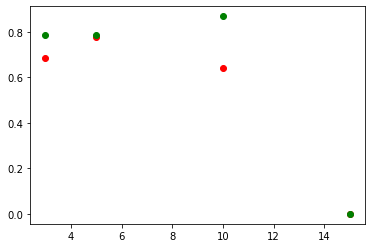

In [ ]:
# Result of s value effect on baselines

plt.scatter([3, 5, 10, 15], MDSvsSimple, color='red')
plt.scatter([3, 5, 10, 15], MDSvsMaj, color='green')

In [ ]:
# same but now for k nearest neighbours and only on MDS and only on 2 learners for speed
# These 2 learners are hard to discern which one is better (done by having checked accuracy of baselines)

MDSAccPerk = []
target = 2048
l1 = 'sklearn.ensemble.GradientBoostingClassifier'
l2 = 'sklearn.ensemble.RandomForestClassifier'

srange = np.arange(3, 15)
krange = np.arange(4, 10)
for k in krange:
    MDSk = []
    for s in srange:
        points = PickAnchors(curves, s, target)
        MDS, _, _, _ = MDSBaseline(l1, l2, curves, k, points, target)
        MDSk.append(MDS)
    MDSAccPerk.append(MDSk)


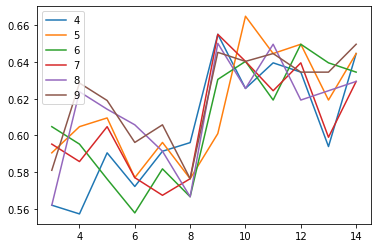

In [ ]:
# result of effect of k only on MDS

for i in range(len(MDSAccPerk)):
    plt.plot(srange, MDSAccPerk[i], label=str(krange[i]))
plt.legend()

In [ ]:
#for 2 other learners, these two are much easier to discern

MDSAccPerk = []
target = 2048
l1 = 'SVC_sigmoid'
l2 = 'sklearn.ensemble.RandomForestClassifier'

srange = np.arange(3, 15)
krange = np.arange(4, 10)
for k in krange:
    MDSk = []
    for s in srange:
        points = PickAnchors(curves, s, target)
        MDS, _, _, _ = MDSBaseline(l1, l2, curves, k, points, target)
        MDSk.append(MDS)
    MDSAccPerk.append(MDSk)

Accuracy is: 0.9348837209302325, totally number of datasets/curves: 215
Accuracy is: 0.9348837209302325, totally number of datasets/curves: 215
Accuracy is: 0.9302325581395349, totally number of datasets/curves: 215
Accuracy is: 0.9295774647887324, totally number of datasets/curves: 213
Accuracy is: 0.9342723004694836, totally number of datasets/curves: 213
Accuracy is: 0.9375, totally number of datasets/curves: 208
Accuracy is: 0.9375, totally number of datasets/curves: 208
Accuracy is: 0.9375, totally number of datasets/curves: 208
Accuracy is: 0.9455445544554455, totally number of datasets/curves: 202
Accuracy is: 0.9504950495049505, totally number of datasets/curves: 202
Accuracy is: 0.9405940594059405, totally number of datasets/curves: 202
Accuracy is: 0.9455445544554455, totally number of datasets/curves: 202
Accuracy is: 0.8883720930232558, totally number of datasets/curves: 215
Accuracy is: 0.9116279069767442, totally number of datasets/curves: 215
Accuracy is: 0.9116279069767

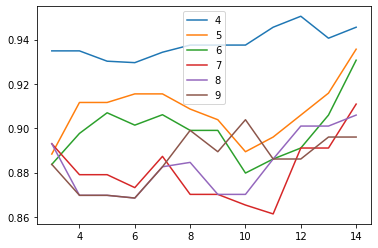

In [ ]:
for i in range(len(MDSAccPerk)):
    plt.plot(srange, MDSAccPerk[i], label=str(krange[i]))
plt.legend()

In [ ]:
# Now only s as k = 5 seems to be sweet spot
# For 2 hard to discern learners

MDSAcc = []
SimpleAcc = []
MajAcc = []
target = 2048
k = 5
l1 = 'sklearn.ensemble.GradientBoostingClassifier'
l2 = 'sklearn.ensemble.RandomForestClassifier'

srange = np.arange(3, 15)

for s in srange:
    points = PickAnchors(curves, s, target)
    MDS, _, _, _ = MDSBaseline(l1, l2, curves, k, points, target)
    Simple, _, _, _ = SimpleBaseline(l1, l2, curves, points, target)
    Maj, _, _, _ = MajorityClassBaseline(l1, l2, curves, target)
    MDSAcc.append(MDS)
    SimpleAcc.append(Simple)
    MajAcc.append(Maj)

Accuracy is: 0.5904761904761905, totally number of datasets/curves: 210
Accuracy is: 0.5904761904761905, totally number of datasets/curves: 210
Accuracy is: 0.5488372093023256, totally number of datasets/curves: 215
Accuracy is: 0.6047619047619047, totally number of datasets/curves: 210
Accuracy is: 0.5904761904761905, totally number of datasets/curves: 210
Accuracy is: 0.5488372093023256, totally number of datasets/curves: 215
Accuracy is: 0.6095238095238096, totally number of datasets/curves: 210
Accuracy is: 0.5904761904761905, totally number of datasets/curves: 210
Accuracy is: 0.5488372093023256, totally number of datasets/curves: 215
Accuracy is: 0.5769230769230769, totally number of datasets/curves: 208
Accuracy is: 0.5865384615384616, totally number of datasets/curves: 208
Accuracy is: 0.5488372093023256, totally number of datasets/curves: 215
Accuracy is: 0.5961538461538461, totally number of datasets/curves: 208
Accuracy is: 0.5865384615384616, totally number of datasets/curv

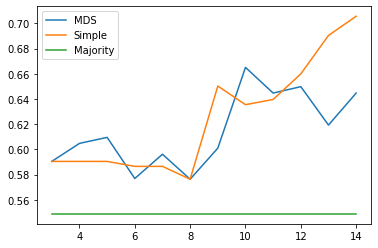

In [ ]:
plt.plot(srange, MDSAcc, label='MDS')
plt.plot(srange, SimpleAcc, label='Simple')
plt.plot(srange, MajAcc, label='Majority')
plt.legend()

In [ ]:
# 2 easily discernable learners

MDSAcc = []
SimpleAcc = []
MajAcc = []
target = 2048
k = 4
l1 = 'SVC_sigmoid'
l2 = 'sklearn.ensemble.RandomForestClassifier'

srange = np.arange(3, 15)

for s in srange:
    points = PickAnchors(curves, s, target)
    MDS, _, _, _ = MDSBaseline(l1, l2, curves, k, points, target)
    Simple, _, _, _ = SimpleBaseline(l1, l2, curves, points, target)
    Maj, _, _, _ = MajorityClassBaseline(l1, l2, curves, target)
    MDSAcc.append(MDS)
    SimpleAcc.append(Simple)
    MajAcc.append(Maj)

Accuracy is: 0.9348837209302325, totally number of datasets/curves: 215
Accuracy is: 0.8651162790697674, totally number of datasets/curves: 215
Accuracy is: 0.9045454545454545, totally number of datasets/curves: 220
Accuracy is: 0.9348837209302325, totally number of datasets/curves: 215
Accuracy is: 0.8651162790697674, totally number of datasets/curves: 215
Accuracy is: 0.9045454545454545, totally number of datasets/curves: 220
Accuracy is: 0.9302325581395349, totally number of datasets/curves: 215
Accuracy is: 0.8651162790697674, totally number of datasets/curves: 215
Accuracy is: 0.9045454545454545, totally number of datasets/curves: 220
Accuracy is: 0.9295774647887324, totally number of datasets/curves: 213
Accuracy is: 0.863849765258216, totally number of datasets/curves: 213
Accuracy is: 0.9045454545454545, totally number of datasets/curves: 220
Accuracy is: 0.9342723004694836, totally number of datasets/curves: 213
Accuracy is: 0.863849765258216, totally number of datasets/curves

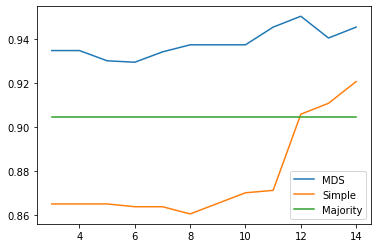

In [ ]:
plt.plot(srange, MDSAcc, label='MDS')
plt.plot(srange, SimpleAcc, label='Simple')
plt.plot(srange, MajAcc, label='Majority')
plt.legend()

# 2nd Try (fixing tournament mode)
The problem with only taking target value as fixed is that not all curves will have finished learning by then. An option is to pick the last anchor point but then we would not be predicting $p_{ref}$. Instead we just eliminate all datasets without $s_{ref}$ as that is the simplest solution.

![1st Try vs 2nd Try](https://drive.google.com/uc?id=1Rvnm8QG4ONIJIG4H1M62-Oyu6AYMCR_Q)


    Broadcasting works by starting witht both rightmost dimensions
    If both dimensions are equal it does the operation position wise
    If one of the dimensions is 1 it will duplicate in that dimension to the size of the other dimension
    
    Einsteinsummation is also very useful. You can use np.einsum to use einstein notation
    '->' is only needed if you want to specify the output like we do here to get the diagonals of the 2D matrix for each learner

## Funcs

### Orig

In [ ]:
def _add_missing(grp,name,index):
    # We set the index to be the column(s) that we want
    # If we only want one column this'll be just a string (can also be list of one string)
    # If we want more this'll be a list of strings (one for each column)
    _ = grp.set_index(name)
    # We tell it all the index values we want (array/list for one column, multindex for multiple columns)
    # It then checks the group if it misses any of those values and adds them (with NaN values in the other columns)
    _ = _.reindex(index)
    # Extra openmlid column gets made so we remove it and so that we can reset the index after
    del _['openmlid']
    return _

def RegularizeDF(dataframe, points = [16, 23, 32, 45, 64, 2048]):
    '''
    Removes the datasets from the dataframe that do not contain the given size_train points
    '''
    regdataframe = dataframe.groupby(['openmlid','learner']).filter(lambda x: x['size_train'].isin(points).sum() == len(points))
    return regdataframe

def MDSCompetitionPredictions(dataframe, k=4, points=[16, 23, 32, 45, 64], target = 2048):
    '''
    Reusing previous code MDSbaseline from part 1 but applying to one dimension higher
    to make it even more efficient, broadcasting even more! Comments here will not repeat 
    what was already commented in part 1, I only comment on any changes that had to be done
    
    WARNING, assumes every dataset has the given size_train points

    :param dataframe: input dataframe of learning curves
    :param k: k-nearest neighbor datasets
    :param points: size_train values of begginning segment
    :return: numpy array where position (l1,l2,ds) represents l1 vs l2 on dataset ds.
      1 represents l1 wins, 0 l2, and np.nan means wither l1 or l2 isn't present in ds or l1=l2
    '''
    s = len(points)
    learners = dataframe['learner'].unique()
    datasets = dataframe['openmlid'].unique()

    # Get every segment and every target (for each learner in each dataset)
    target = dataframe[dataframe['size_train'] == target]
    segment = dataframe[dataframe['size_train'].isin(points)]

    # To get an array that works nice with numpy (63,20,x) we need all 20 learners in each of the 63 datasets. Thus we can pad them in
    multind = pd.MultiIndex.from_product([learners,points])
    target = target.groupby(['openmlid']).apply(lambda grp: _add_missing(grp,'learner',learners)).reset_index().fillna(np.nan)
    segment = segment.groupby(['openmlid']).apply(lambda grp: _add_missing(grp,['learner','size_train'],multind)).reset_index().fillna(np.nan)

    # We end up with numpy array target and segment, the shape of segment is (63 dataset,20 learner,5 size_train for segment)
    # We swap around the first two axis to get (20,63,x) so that I can more easily implement my previous MDS code
    target = target['score_test'].values.reshape(-1,len(learners)).T
    segment = segment['score_test'].values.reshape(-1,len(learners), s).swapaxes(0,1)

    ### Done with preprocessing now the actual calculations
    weights = np.arange(1, s + 1) ** 2
    scalar = np.sum(weights * segment[:,:,np.newaxis] * segment[:, np.newaxis],axis=-1)/np.sum(weights * (segment ** 2), axis=-1)[:,np.newaxis]

    # ..., is used to get to last dimension easily
    pairs = scalar[...,np.newaxis]*segment[:,np.newaxis]
    scaled_target = scalar * target[:,np.newaxis]

    distance = np.sum((pairs - segment[:,np.newaxis]) ** 2, axis = -1)
    # Again [...], however as nothing after it, its the same as just doing [:] or [:,:]
    # we do it as we want to fill the array not change the array into np.nan
    np.einsum('ijj->ij', distance)[...] = np.nan
    distancesum = distance[:,np.newaxis] + distance

    # Had to redo this part since indexing became annoying in higher dimension
    # We partition the last axis as that is the list of all the distances we want to partition
    k_index = np.argpartition(distancesum, k, axis = -1)[...,:k]
    # Sadly a for loop as I couldn't figure out how to index scaled_target multiple times each time with a different i for k_index[i]
    #============================== IMPORTANT: this could be np.nanmean. If k is so big that there are no more valid other datasets
    # it will start taking the invalid ones which have np.nan, if there is at least one np.nan the mean will give np.nan. However,
    # using np.nanmean the np.nan's are skipped over entirely, so np.nanmean([np.nan,0,1]) = 0.5 =======================================
    prediction = np.mean(np.array([np.take_along_axis(scaled_target,k_index[i],axis=-1) for i in range(scaled_target.shape[0])]),axis=-1)
    # Idea is the following, prediction[i,j,k] gives the prediction for learner j when it is i vs j (on dataset k)
    # so swapping the first two indices gives us the same prediction for learner i
    Tprediction = np.einsum('ij...->ji...',prediction)
    ans = (Tprediction >= prediction).astype('float64') #float so that np.nan's can be put in as well
    ans[Tprediction == prediction] = 0.5 #Ties
    # np.nan's have to stay as nan's, in inequality they get transformed as np.nan > any number
    ans[np.isnan(prediction)] = np.nan
    ans[np.isnan(Tprediction)] = np.nan
    # no free point when competing against yourself
    np.einsum('iij->ij',ans)[...] = np.nan

    return ans, prediction

def MDSregression(dataframe, k=4, points=[16, 23, 32, 45, 64], target = 2048):
    s = len(points)
    learners = dataframe['learner'].unique()
    datasets = dataframe['openmlid'].unique()

    # Get every segment and every target (for each learner in each dataset)
    target = dataframe[dataframe['size_train'] == target]
    segment = dataframe[dataframe['size_train'].isin(points)]

    # To get an array that works nice with numpy (63,20,x) we need all 20 learners in each of the 63 datasets. Thus we can pad them in
    multind = pd.MultiIndex.from_product([learners,points])
    target = target.groupby(['openmlid']).apply(lambda grp: _add_missing(grp,'learner',learners)).reset_index().fillna(np.nan)
    segment = segment.groupby(['openmlid']).apply(lambda grp: _add_missing(grp,['learner','size_train'],multind)).reset_index().fillna(np.nan)

    # We end up with numpy array target and segment, the shape of segment is (63 dataset,20 learner,5 size_train for segment)
    # We swap around the first two axis to get (20,63,x) so that I can more easily implement my previous MDS code
    target = target['score_test'].values.reshape(-1,len(learners)).T
    segment = segment['score_test'].values.reshape(-1,len(learners), s).swapaxes(0,1)

    ### Done with preprocessing now the actual calculations
    weights = np.arange(1, s + 1) ** 2
    scalar = np.sum(weights * segment[:,:,np.newaxis] * segment[:, np.newaxis],axis=-1)/np.sum(weights * (segment ** 2), axis=-1)[:,np.newaxis]
    scaled_target = scalar * target[:,np.newaxis]
    distance = np.sum((segment[:,:,np.newaxis] - segment[:,np.newaxis]) ** 2, axis = -1)
    np.einsum('ijj->ij', distance)[...] = np.nan

    # We partition the last axis as that is the list of all the distances we want to partition
    k_index = np.argpartition(distance, k, axis = -1)[...,:k]
    prediction = np.mean(np.take_along_axis(scaled_target,k_index,axis = -1), axis = -1)

    return prediction.T

def MDSscaleafter(dataframe, k=4, points=[16, 23, 32, 45, 64], target = 2048):
    '''
    Same as MDSCompetitionPredictions however now we do k-nn without scaling first.
    After the k-nn picks out the curves we apply the scaling (which only affects the target)
    '''
    s = len(points)
    learners = dataframe['learner'].unique()
    datasets = dataframe['openmlid'].unique()

    # Get every segment and every target (for each learner in each dataset)
    target = dataframe[dataframe['size_train'] == target]
    segment = dataframe[dataframe['size_train'].isin(points)]

    # To get an array that works nice with numpy (63,20,x) we need all 20 learners in each of the 63 datasets. Thus we can pad them in
    multind = pd.MultiIndex.from_product([learners,points])
    target = target.groupby(['openmlid']).apply(lambda grp: _add_missing(grp,'learner',learners)).reset_index().fillna(np.nan)
    segment = segment.groupby(['openmlid']).apply(lambda grp: _add_missing(grp,['learner','size_train'],multind)).reset_index().fillna(np.nan)

    # We end up with numpy array target and segment, the shape of segment is (63 dataset,20 learner,5 size_train for segment)
    # We swap around the first two axis to get (20,63,x) so that I can more easily implement my previous MDS code
    target = target['score_test'].values.reshape(-1,len(learners)).T
    segment = segment['score_test'].values.reshape(-1,len(learners), s).swapaxes(0,1)

    ### Done with preprocessing now the actual calculations
    weights = np.arange(1, s + 1) ** 2
    scalar = np.sum(weights * segment[:,:,np.newaxis] * segment[:, np.newaxis],axis=-1)/np.sum(weights * (segment ** 2), axis=-1)[:,np.newaxis]

    # ..., is used to get to last dimension easily
    pairs = scalar[...,np.newaxis]*segment[:,np.newaxis]
    scaled_target = scalar * target[:,np.newaxis]

    # scale after retrieving
    distance = np.sum((segment[:,:,np.newaxis] - segment[:,np.newaxis]) ** 2, axis = -1)
    # Again [...], however as nothing after it, its the same as just doing [:] or [:,:]
    # we do it as we want to fill the array not change the array into np.nan
    np.einsum('ijj->ij', distance)[...] = np.nan
    distancesum = distance[:,np.newaxis] + distance

    # Had to redo this part since indexing became annoying in higher dimension
    # We partition the last axis as that is the list of all the distances we want to partition
    k_index = np.argpartition(distancesum, k, axis = -1)[...,:k]
    # Sadly a for loop as I couldn't figure out how to index scaled_target multiple times each time with a different i for k_index[i]
    #============================== IMPORTANT: this could be np.nanmean. If k is so big that there are no more valid other datasets
    # it will start taking the invalid ones which have np.nan, if there is at least one np.nan the mean will give np.nan. However,
    # using np.nanmean the np.nan's are skipped over entirely, so np.nanmean([np.nan,0,1]) = 0.5 =======================================
    prediction = np.mean(np.array([np.take_along_axis(scaled_target,k_index[i],axis=-1) for i in range(scaled_target.shape[0])]),axis=-1)
    # Idea is the following, prediction[i,j,k] gives the prediction for learner j when it is i vs j (on dataset k)
    # so swapping the first two indices gives us the same prediction for learner i
    Tprediction = np.einsum('ij...->ji...',prediction)
    ans = (Tprediction >= prediction).astype('float64') #float so that np.nan's can be put in as well
    ans[Tprediction == prediction] = 0.5 #Ties
    # np.nan's have to stay as nan's, in inequality they get transformed as np.nan > any number
    ans[np.isnan(prediction)] = np.nan
    ans[np.isnan(Tprediction)] = np.nan
    # no free point when competing against yourself
    np.einsum('iij->ij',ans)[...] = np.nan

    return ans, prediction

def CompetitionResults(dataframe, target = 2048):
    '''
    Returns the same array as MDS but gives the actual results, no prediction is made.
    Truth reference.
    '''
    learners = dataframe['learner'].unique()
    datasets = dataframe['openmlid'].unique()

    # Take target as np array and pad missing as in MDS
    target = dataframe[dataframe['size_train'] == target]
    target = target.groupby(['openmlid']).apply(lambda grp: _add_missing(grp,'learner',learners)).reset_index().fillna(np.nan)
    target = target['score_test'].values.reshape(-1,len(learners)).T

    # Broadcasting to check who is the winner, then recovering np.nan's as in MDS
    ans = (target[:,np.newaxis] >= target).astype('float64')
    # Ties are 0.5! This is to make sure opposites add up to 1
    ans[target[:,np.newaxis] == target] = 0.5
    ans[:,np.isnan(target)] = np.nan
    np.einsum('ij... ->ji...',ans)[:,np.isnan(target)] = np.nan
    np.einsum('iij->ij',ans)[...] = np.nan # no free point

    return ans  

def SimpleCompetitionPredictions(dataframe, points=[16, 23, 32, 45, 64]):
    '''
    The Simple baseline simply picks the learner with the better score at the last available size_train segment point.
    As with MDS each dataset needs to contain all the given size_train points.
    One could also just input the last point of the segment into the function and it would do the same
    '''
    # Same as in MDS, however we only need the last point
    learners = dataframe['learner'].unique()
    datasets = dataframe['openmlid'].unique()
    segLastPoint = dataframe[dataframe['size_train'] == points[-1]]
    segLastPoint = segLastPoint.groupby(['openmlid']).apply(lambda grp: _add_missing(grp,'learner',learners)).reset_index().fillna(np.nan)
    segLastPoint = segLastPoint['score_test'].values.reshape(-1,len(learners)).T

    # Same as in CompetitionResults
    ans = (segLastPoint[:,np.newaxis] >= segLastPoint).astype('float64')
    ans[segLastPoint[:,np.newaxis] == segLastPoint] = 0.5
    ans[:,np.isnan(segLastPoint)] = np.nan
    np.einsum('ij... ->ji...',ans)[:,np.isnan(segLastPoint)] = np.nan
    np.einsum('iij->ij',ans)[...] = np.nan

    return ans

def MajorityClassCompetitionPredictions(results):
    '''
    The majority class baseline will always pick the class which wins most often over all the other datasets
    '''
    # We want to take an average over all the other datasets, as if we do not know
    # the result of the current dataset. We do this by taking the mean manually. 
    # After this we can just round to get the winning class

    # We get the actual results and get a count of how many non nan values there
    # are so that we can normalize the sum. We subtract 1 from this as the average
    # is taken over all the other datasets, so the given value isn't included.
    cnt = np.sum(~np.isnan(results),axis=-1)-1
    # We want sum without the given value
    sum = np.nansum(results, axis = -1)[...,np.newaxis] - results
    ans = sum/cnt[...,np.newaxis]

    # so that ties stay as ties and are not rounded we mask them out
    ans[ans != 0.5] = np.round(ans[ans != 0.5])

    return ans

def MMFbaseline(dataframe, points=[16, 23, 32, 45, 64], target_point = 2048, method = 'Powell'):
    '''
    MMF assumes the following shape model y = (a ∗ b + c ∗ x**d)/(b + x**d)
    so we use scipy.optimize.minimize to find out a,b,c,d for each curve
    and then predict at target point 
    
    WARNING, assumes every dataset has the given size_train points

    :param dataframe: input dataframe of learning curves
    :param k: k-nearest neighbor datasets
    :param points: size_train values of begginning segment
    :return: numpy array where position (ds,l1,l2) represents l1 vs l2 on dataset ds.
      1 represents l1 wins, 0 l2, and np.nan means wither l1 or l2 isn't present in ds or l1=l2
    '''
    s = len(points)
    points = np.array(points)
    learners = dataframe['learner'].unique()
    datasets = dataframe['openmlid'].unique()

    # Get every segment and every target (for each learner in each dataset)
    target = dataframe[dataframe['size_train'] == target_point]
    segment = dataframe[dataframe['size_train'].isin(points)]

    # To get an array that works nice with numpy (63,20,x) we need all 20 learners in each of the 63 datasets. Thus we can pad them in
    multind = pd.MultiIndex.from_product([learners,points])
    target = target.groupby(['openmlid']).apply(lambda grp: _add_missing(grp,'learner',learners)).reset_index().fillna(np.nan)
    segment = segment.groupby(['openmlid']).apply(lambda grp: _add_missing(grp,['learner','size_train'],multind)).reset_index().fillna(np.nan)

    # We end up with numpy array target and segment, the shape of segment is (63 dataset,20 learner,5 size_train for segment)
    target = target['score_test'].values.reshape(-1,len(learners))
    segment = segment['score_test'].values.reshape(-1,len(learners), s)

    ### Done with preprocessing now the actual calculations
    weights = 2**np.arange(s)
    params = []
    pred_tar = []
    penalty = []
    success = []
    
    # We do a for loop over all the curves (first ds then learners) as I tested 
    # it out and this is faster for scipy.optimize.minimize (about 20 seconds)
    for ds in segment:
      for curve in ds:
        if np.isnan(curve[0]):
          # If the curve for the learner doesn't exist we skip it
          # this can be seen by if its first value is np.nan
          params.append([np.nan,np.nan,np.nan,np.nan])
          pred_tar.append(np.nan)
          continue

        def mmf(beta):
          # Calculating loss of mmf model
          a, b, c, d = tuple(beta.astype(float))
          fun = lambda x: (a * b + c * x ** d)/(b + x ** d)
          penalties = weights*((curve - fun(points))**2)
          penalties[np.isnan(penalties)] = 10**6
          if method == 'lm':
            penalties = np.sqrt(weights)*(curve - fun(points))
            return penalties
          return np.sum(penalties)
        
        # No idea why this is here
        factor = 1

        # Constraint is that b*(c-a)*d > 0
        const = {
            "type": "ineq", "fun": lambda x: -factor * x[1] * (x[2]-x[0])*x[3],
        }
        if method == 'default':
          res = minimize(mmf, np.array([0.5,1,1,-1]), constraints=const)
        elif method == 'noconst':
          res = minimize(mmf, np.array([0.5,1,1,-1]))
        elif method == 'lm':
          res = least_squares(mmf, np.array([0.5,1,1,-1]), method = 'lm')
        elif method == 'Powell':
          res = minimize(mmf, np.array([0.5,1,1,-1]), constraints=const, method = 'Powell')
        elif method == 'Nelder-Mead':
          res = minimize(mmf, np.array([0.5,1,1,-1]), constraints=const, method = 'Nelder-Mead')
        a, b, c, d = tuple(res.x)
        penalty.append(res.fun)
        params.append([a,b,c,d])
        success.append(res.success)
        pred_tar.append((a * b + c * target_point ** d)/(b + target_point ** d))
    
    params = np.array(params)
    pred_tar = np.array(pred_tar).reshape(target.shape)
    ans = (pred_tar[...,np.newaxis] > pred_tar[:,np.newaxis]).astype('float64')
    ans[pred_tar[...,np.newaxis] == pred_tar[:,np.newaxis]] = 0.5
    ans[np.isnan(pred_tar),:] = np.nan
    np.einsum('ijk ->ikj',ans)[np.isnan(pred_tar),:] = np.nan
    np.einsum('ijj ->ij',ans)[...] = np.nan
    
    def mmf_model(x,beta):
      return (beta[:,0] * beta[:,1] + beta[:,2] * x ** beta[:,3])/(beta[:,1] + x ** beta[:,3])

    prediction = mmf_model(target_point,params)
    testError = np.abs(target.flatten() - prediction).reshape(target.shape)
    
    prediction = mmf_model(np.array(points), params[...,None]).reshape(segment.shape)
    trainError = np.abs(prediction-segment)


    return ans, penalty, success, params, trainError, testError

def MMFTensorized(dataframe, points=[16, 23, 32, 45, 64], target_point = 2048, steps = 500):
    s = len(points)
    points = np.array(points)
    learners = dataframe['learner'].unique()
    datasets = dataframe['openmlid'].unique()

    # Get every segment and every target (for each learner in each dataset)
    target = dataframe[dataframe['size_train'] == target_point]
    segment = dataframe[dataframe['size_train'].isin(points)]

    # To get an array that works nice with numpy (63,20,x) we need all 20 learners in each of the 63 datasets. Thus we can pad them in
    multind = pd.MultiIndex.from_product([learners,points])
    target = target.groupby(['openmlid']).apply(lambda grp: _add_missing(grp,'learner',learners)).reset_index().fillna(np.nan)
    segment = segment.groupby(['openmlid']).apply(lambda grp: _add_missing(grp,['learner','size_train'],multind)).reset_index().fillna(np.nan)

    # We end up with numpy array target and segment, the shape of segment is (63 dataset,20 learner,5 size_train for segment)
    target = target['score_test'].values.reshape(-1,len(learners))
    segment = segment['score_test'].values.reshape(-1,len(learners), s)

    target = torch.tensor(target)
    segment = torch.tensor(segment)
    points = torch.tensor(points)[None,None]

    ### Done with preprocessing
    weights = (2**torch.arange(s))
    params = torch.tensor([0.5,1,1,-1])
    params = params.repeat(len(datasets),len(learners),1)[...,None]
    params.requires_grad_()
    gr = torch.ones((len(datasets),len(learners)))

    def mmf_func(beta,x):
      return (beta[:,:,0] * beta[:,:,1] + beta[:,:,2] * x ** beta[:,:,3])/(beta[:,:,1] + x ** beta[:,:,3])

    optimizer = torch.optim.Adam([params], lr=0.1)
    for i in range(steps):
      optimizer.zero_grad()
      penalties = (((segment - mmf_func(params,points))**2)*weights).sum(-1)
      penalties.backward(gradient = gr)
      optimizer.step()
    
    params.requires_grad = False
    trainError = (segment - mmf_func(params,points)).abs()

    target_point = torch.tensor([target_point])[None,None]
    prediction = mmf_func(params,target_point).squeeze()

    testError = (target - prediction).abs()

    ans = (prediction[...,None] > prediction[:,None]).type(torch.FloatTensor)
    ans[prediction[...,None] == prediction[:,None]] = 0.5
    ans[torch.isnan(prediction[...,None] + prediction[:,None])] = np.nan
    torch.einsum('ijj ->ij',ans)[...] = np.nan

    return ans.numpy(), params.numpy(),trainError.numpy(),testError.numpy()


### Class try 1

In [ ]:
class Window:
  Slearners = np.array(['SVCl','SVCp', 'SVCr', 'SVCs','xTrs','GrBo','rFor','LogR','PaAg', 'Perc', 'Ridg', 'SGD','Bern','MuNo', 'KNei', 'MLP', 'dTre', 'xTre','linD','QuaD'])
  train_size = train_size_count.index.values
  train_size_count = train_size_count.values.reshape(-1)
  reg_size_train = train_size[train_size_count > 100]

  def __init__(self, orig_dataframe, points = [16, 23, 32, 45, 64], target_point = 2048):
    self.orig_dataframe = orig_dataframe
    self.results = {}
    if points:
      self.points = points
      self.target_point = target_point
      self._RegularizeDF()
  
  def _add_missing(grp,name,index):
    # We set the index to be the column(s) that we want
    # If we only want one column this'll be just a string (can also be list of one string)
    # If we want more this'll be a list of strings (one for each column)
    _ = grp.set_index(name)
    # We tell it all the index values we want (array/list for one column, multindex for multiple columns)
    # It then checks the group if it misses any of those values and adds them (with NaN values in the other columns)
    _ = _.reindex(index)
    # Extra openmlid column gets made so we remove it and so that we can reset the index after
    del _['openmlid']
    return _
  
  def _RegularizeDF(self, regularize = True):
    '''
    Removes the datasets from the dataframe that do not contain the given size_train points.
    Also puts the relevant data into a numpy array
    '''

    self.s = len(self.points)
    if regularize:
      self.dataframe = self.orig_dataframe.groupby(['openmlid','learner']).filter(lambda x: x['size_train'].isin(self.points+[self.target_point]).sum() == self.s+1)
    self.learners = self.dataframe['learner'].unique()
    self.datasets = self.dataframe['openmlid'].unique()
    
    # Get every segment and every target (for each learner in each dataset)
    target = self.dataframe[self.dataframe['size_train'] == self.target_point]
    segment = self.dataframe[self.dataframe['size_train'].isin(self.points)]

    # To get an array that works nice with numpy (63,20,x) we need all 20 learners in each of the 63 datasets. Thus we can pad them in
    multind = pd.MultiIndex.from_product([self.learners,self.points])
    target = target.groupby(['openmlid']).apply(lambda grp: _add_missing(grp,'learner',self.learners)).reset_index().fillna(np.nan)
    segment = segment.groupby(['openmlid']).apply(lambda grp: _add_missing(grp,['learner','size_train'],multind)).reset_index().fillna(np.nan)

    # We end up with numpy array target and segment, the shape of segment is (63 dataset,20 learner,5 size_train for segment)
    self.target = target['score_test'].values.reshape(-1,len(self.learners))
    self.segment = segment['score_test'].values.reshape(-1,len(self.learners), self.s)
    # We swap around the first two axis to get (20,63,x) so that I can more easily implement my previous MDS code
    self.targetT = self.target.T
    self.segmentT = self.segment.swapaxes(0,1)

  def MDS(self, k = 4, points=None, target_point = None, regularize = False):
    '''
    Reusing previous code MDSbaseline from part 1 but applying to one dimension higher
    to make it even more efficient, broadcasting even more! Comments here will not repeat 
    what was already commented in part 1, I only comment on any changes that had to be done
    
    WARNING, assumes every dataset has the given size_train points

    :param dataframe: input dataframe of learning curves
    :param k: k-nearest neighbor datasets
    :param points: size_train values of begginning segment
    :return: numpy array where position (l1,l2,ds) represents l1 vs l2 on dataset ds.
      1 represents l1 wins, 0 l2, and np.nan means wither l1 or l2 isn't present in ds or l1=l2
    '''
    if points:
      self.points = points
      self.target_point = target_point
      self._RegularizeDF(regularize = regularize)

    ### Done with preprocessing now the actual calculations
    weights = np.arange(1, self.s + 1) ** 2
    scalar = np.sum(weights * self.segmentT[:,:,np.newaxis] * self.segmentT[:, np.newaxis],axis=-1)/np.sum(weights * (self.segmentT ** 2), axis=-1)[:,np.newaxis]

    # ..., is used to get to last dimension easily
    pairs = scalar[...,np.newaxis]*self.segmentT[:,np.newaxis]
    scaled_target = scalar * self.targetT[:,np.newaxis]
    self.scalar = scalar
    self.scaled_segment = pairs
    self.scaled_target = scaled_target


    distance = np.sum((pairs - self.segmentT[:,np.newaxis]) ** 2, axis = -1)
    distanceScaleAfter = np.sum((self.segmentT[:,:,np.newaxis] - self.segmentT[:,np.newaxis]) ** 2, axis = -1)
    # Again [...], however as nothing after it, its the same as just doing [:] or [:,:]
    # we do it as we want to fill the array not change the array into np.nan
    np.einsum('ijj->ij', distance)[...] = np.nan
    np.einsum('ijj->ij', distanceScaleAfter)[...] = np.nan
    
    distancesum = distance[:,np.newaxis] + distance
    distancesumScaleAfter = distanceScaleAfter[:,np.newaxis] + distanceScaleAfter
    
    # Had to redo this part since indexing became annoying in higher dimension
    # We partition the last axis as that is the list of all the distances we want to partition
    k_index = np.argpartition(distancesum, k, axis = -1)[...,:k]
    # Sadly a for loop as I couldn't figure out how to index scaled_target multiple times each time with a different i for k_index[i]
    #============================== IMPORTANT: this could be np.nanmean. If k is so big that there are no more valid other datasets
    # it will start taking the invalid ones which have np.nan, if there is at least one np.nan the mean will give np.nan. However,
    # using np.nanmean the np.nan's are skipped over entirely, so np.nanmean([np.nan,0,1]) = 0.5 =======================================
    prediction = np.mean(np.array([np.take_along_axis(scaled_target,k_index[i],axis=-1) for i in range(scaled_target.shape[0])]),axis=-1)
    # Idea is the following, prediction[i,j,k] gives the prediction for learner j when it is i vs j (on dataset k)
    # so swapping the first two indices gives us the same prediction for learner i
    Tprediction = np.einsum('ij...->ji...',prediction)
    ans = (Tprediction >= prediction).astype('float64') #float so that np.nan's can be put in as well
    ans[Tprediction == prediction] = 0.5 #Ties
    # np.nan's have to stay as nan's, in inequality they get transformed as np.nan > any number
    ans[np.isnan(prediction)] = np.nan
    ans[np.isnan(Tprediction)] = np.nan
    # no free point when competing against yourself
    np.einsum('iij->ij',ans)[...] = np.nan


    k_indexScaleAfter = np.argpartition(distancesumScaleAfter, k, axis = -1)[...,:k]
    predictionScaleAfter = np.mean(np.array([np.take_along_axis(scaled_target,k_indexScaleAfter[i],axis=-1) for i in range(scaled_target.shape[0])]),axis=-1)
    TpredictionScaleAfter = np.einsum('ij...->ji...',predictionScaleAfter)
    ansScaleAfter = (TpredictionScaleAfter >= predictionScaleAfter).astype('float64') #float so that np.nan's can be put in as well
    ansScaleAfter[TpredictionScaleAfter == predictionScaleAfter] = 0.5 #Ties
    ansScaleAfter[np.isnan(predictionScaleAfter)] = np.nan
    ansScaleAfter[np.isnan(TpredictionScaleAfter)] = np.nan
    np.einsum('iij->ij',ansScaleAfter)[...] = np.nan
    
    # We partition the last axis as that is the list of all the distances we want to partition
    k_indexReg = np.argpartition(distanceScaleAfter, k, axis = -1)[...,:k]
    predictionReg = np.mean(np.take_along_axis(scaled_target,k_indexReg,axis = -1), axis = -1).T

    ErrorMDS = np.abs(np.nanmean(prediction, axis = 1) - self.targetT).T
    ErrorMDSScaleAfter = np.abs(np.nanmean(predictionScaleAfter, axis = 1) - self.targetT).T
    ErrorMDSReg = np.abs(self.target-predictionReg)

    self.results['MDS'] = {'binary': ans,'regression': prediction, 'test error': ErrorMDS, 'knn': k_index}
    self.results['MDS regression'] = {'regression': predictionReg, 'test error': ErrorMDSReg, 'knn': k_indexReg}
    self.results['MDS scale after'] = {'binary': ansScaleAfter, 'regression': predictionScaleAfter, 'test error': ErrorMDSScaleAfter, 'knn': k_indexScaleAfter}
    return ans, prediction, ansScaleAfter, predictionScaleAfter, predictionReg

  def MMF(self, points=None, target_point = None, steps = 500, regularize = False):
    '''
    MMF assumes the following shape model y = (a ∗ b + c ∗ x**d)/(b + x**d)
    so we use scipy.optimize.minimize to find out a,b,c,d for each curve
    and then predict at target point 
    
    WARNING, assumes every dataset has the given size_train points
    '''
    if points:
      self.points = points
      self.target_point = target_point
      self._RegularizeDF(regularize = regularize)

    # Tensorise variables
    target = torch.tensor(self.target)
    segment = torch.tensor(self.segment)
    points = torch.tensor(self.points)[None,None]
    
    weights = (2**torch.arange(self.s))
    params = torch.tensor([0.5,1,1,-1])
    params = params.repeat(len(self.datasets),len(self.learners),1)[...,None]
    params.requires_grad_()
    gr = torch.ones((len(self.datasets),len(self.learners))) # For .backward(), usually only takes a scalar but with this it doesn't need  to

    # Func to optimise
    def mmf_func(beta,x):
      return (beta[:,:,0] * beta[:,:,1] + beta[:,:,2] * x ** beta[:,:,3])/(beta[:,:,1] + x ** beta[:,:,3])

    optimizer = torch.optim.Adam([params], lr=0.1) # SGD did weird things, Adam works well!
    for i in range(steps):
      optimizer.zero_grad()
      # Sum over last dim, watch out with nan's maybe?
      penalties = (((segment - mmf_func(params,points))**2)*weights).nansum(-1)
      # Each curve has separate .backward() with this
      penalties.backward(gradient = gr)
      optimizer.step()
    
    params.requires_grad = False # To not waste computation
    target_point = torch.tensor([self.target_point])[None,None]
    prediction = mmf_func(params,target_point).squeeze()

    trainError = (segment - mmf_func(params,points)).abs()
    testError = (target - prediction).abs()

    ans = (prediction[...,None] > prediction[:,None]).type(torch.FloatTensor)
    ans[prediction[...,None] == prediction[:,None]] = 0.5
    ans[torch.isnan(prediction[...,None] + prediction[:,None])] = np.nan
    torch.einsum('ijj ->ij',ans)[...] = np.nan

    self.results['MMF'] = {'binary':ans.numpy(), 'regression':prediction.numpy(), 'train error': trainError.numpy(),'test error': testError.numpy(), 'parameters': params.numpy()}
    return ans.numpy(), params.numpy(), trainError.numpy(), testError.numpy()
    
  def MMFvsMDS(self, points=None, target_point = None, steps = 500,  k = 4, ylabel = 'Difference in Test Error', hline = 0, ylim = None, label = True, min = -1, max = 1, cmap = 'seismic', regularize = False):
      
    if points:
      self.points = points
      self.target_point = target_point
      self._RegularizeDF(regularize = regularize)
      self.MMF(steps = 500)
      self.MDS(k = 4)

    mmf_test_err = self.results['MMF']['test error']
    mdsreg_test_err = self.results['MDS regression']['test error']
    data = (mmf_test_err-mdsreg_test_err).T

    fig,ax = plt.subplots(2,1, figsize = [6.4*(4),4.8*(4)])
    axis = ax.flatten()
    
    fig.suptitle(f'MMF (negative) vs MDS regression (positive) prediction error for points: {self.points} and target point: {self.target_point}', y=0.9)
    sns.heatmap(data, cmap = cmap, vmin = min, vmax = max, ax = axis[0])
    if label:
      axis[0].set_yticklabels(Slearners, rotation = 0)
    axis[1].boxplot(data[~np.isnan(data)].ravel())
    if ylim:
      axis[1].set_ylim(*ylim)
    if ylabel:
      axis[1].set_ylabel(ylabel)
    if hline != 'N':
      axis[1].axhline(hline,linestyle = '--')
    
    fig.show()
  
  def scatter(self, learner, dataset, scaled = True, ylabel = None, title = None):

    if type(learner) == str:
      learnerID = np.where(self.Slearners == learner)[0][0]
    else:
      learnerID = learner
    
    if type(dataset) == str:
      datasetID = np.where(self.datasets.astype(str) == dataset)
    else:
      datasetID = dataset

    fig,ax = plt.subplots(1,1,figsize = [6.4,4.8])
    
    if title:
      fig.suptitle(title, y=0.9)
    if ylabel:
      ax.set_ylabel(ylabel)
    
    # Curve points, we also take the regularised points and put them back in to see
    ax.scatter(self.points,self.segment[datasetID,learnerID], color = 'blue', marker = 'o')
    ax.scatter(self.target_point, self.target[datasetID,learnerID],color = 'red')
    
    dat = aggCurves[aggCurves['openmlid'] == self.datasets[datasetID]]
    dat = dat[dat['learner'] == self.learners[learnerID]]
    points = dat['size_train'].values
    stop = np.where(points == self.target_point)[0][0]
    segment = dat['score_test'].values[:stop]
    ax.scatter(points[:stop],segment, color = 'blue', marker = 'x')

    # MMF prediction plot
    x = np.linspace(self.points[0],self.target_point,10000)
    a,b,c,d = self.results['MMF']['parameters'][datasetID,learnerID]
    fun = lambda x: (a * b + c * x ** d)/(b + x ** d)
    ax.plot(x,fun(x))

    # MDS regression k-nearest neighbors, also put the regularised points back in
    knn = self.results['MDS regression']['knn'][learnerID,datasetID]

    for i in knn:
      dat = aggCurves[aggCurves['openmlid'] == self.datasets[i]]
      dat = dat[dat['learner'] == self.learners[learnerID]]
      points = dat['size_train'].values
      stop = np.where(points == self.target_point)[0][0]
      segment = dat['score_test'].values[:stop+1] * self.scalar[learnerID,datasetID, i]
      ax.scatter(points[:stop+1],segment, s = 5)
    
    # MDS regression prediction
    plt.scatter(self.target_point, self.results['MDS regression']['regression'][datasetID,learnerID], color = 'red', marker = 'x')

  def windowing(self, start, stop, target_point = 2048):
      
    self.points = [start]
    self.target_point = target_point
    self._RegularizeDF()
    train_sizes = self.reg_size_train[:np.where(self.reg_size_train==stop)[0][0]+1]
    points = []
    fig, ax =plt.subplots(2,1, figsize = [6.4*2,4.8*2])
    pos = np.arange(0,len(train_sizes))
    MMF_errors = []
    mdsreg_errors = []
    for i in range(len(train_sizes)):
      points.append(train_sizes[i])
      self.points = points
      self._RegularizeDF(regularize = False)
      self.MDS()
      self.MMF()
      MMF_error = self.results['MMF']['test error']
      mdsreg_error = self.results['MDS regression']['test error']
      MMF_errors.append(MMF_error[~np.isnan(MMF_error)].ravel())
      mdsreg_errors.append(mdsreg_error[~np.isnan(mdsreg_error)].ravel())
      
    
    ax[0].boxplot(MMF_errors, positions = pos, showmeans = True)
    ax[1].boxplot(mdsreg_errors, positions = pos, showmeans = True)
    ax[0].set_title('MMF Errors')
    ax[0].set_xticklabels(train_sizes)
    ax[1].set_title('MDS Errors')
    ax[1].set_xticklabels(train_sizes)
    ax[0].set_ylim((0,1))
    ax[1].set_ylim((0,1))
    return fig,ax

### Class try 2

In [ ]:
class Windowing:
  Slearners = np.array(['SVCl','SVCp', 'SVCr', 'SVCs','xTrs','GrBo','rFor','LogR','PaAg', 'Perc', 'Ridg', 'SGD','Bern','MuNo', 'KNei', 'MLP', 'dTre', 'xTre','linD','QuaD'])

  def __init__(self, orig_dataframe):
    self.orig_dataframe = orig_dataframe
    self.results = {}
    '''
    To pick what anchor points we want to analyse the distribution of data on each anchor point.

    '''
    train_size_count = self.orig_dataframe.groupby(['openmlid','size_train']).first().reset_index().groupby(['size_train'])[['size_train']].count().rename(columns = {'size_train':'Count'})
    display(train_size_count)
    self.train_size = train_size_count.index.values
    self.train_size_count = train_size_count.values.reshape(-1)

  def set_points(self, points, target_point):
    self.points = points
    self.s = len(points)
    self.target_point = target_point
    self._RegularizeDF()
    self._DFtoNumpy()
    self.results = {}
  
  def _add_missing(self,grp,name,index):
    # We set the index to be the column(s) that we want
    # If we only want one column this'll be just a string (can also be list of one string)
    # If we want more this'll be a list of strings (one for each column)
    _ = grp.set_index(name)
    # We tell it all the index values we want (array/list for one column, multindex for multiple columns)
    # It then checks the group if it misses any of those values and adds them (with NaN values in the other columns)
    _ = _.reindex(index)
    # Extra openmlid column gets made so we remove it and so that we can reset the index after
    del _['openmlid']
    return _
  
  def _RegularizeDF(self):
    '''
    Removes the datasets from the dataframe that do not contain the given size_train points.
    Also puts the relevant data into a numpy array
    '''
    self.dataframe = self.orig_dataframe.groupby(['openmlid','learner']).filter(lambda x: x['size_train'].isin(self.points+[self.target_point]).sum() == self.s+1)
    self.learners = self.dataframe['learner'].unique()
    self.datasets = self.dataframe['openmlid'].unique()

  def _DFtoNumpy(self):
    # Get every segment and every target (for each learner in each dataset)
    target = self.dataframe[self.dataframe['size_train'] == self.target_point]
    segment = self.dataframe[self.dataframe['size_train'].isin(self.points)]

    # To get an array that works nice with numpy we need all learners in each of the datasets. Thus we can pad them in
    multind = pd.MultiIndex.from_product([self.learners,self.points])
    target = target.groupby(['openmlid']).apply(lambda grp: self._add_missing(grp,'learner',self.learners)).reset_index().fillna(np.nan)
    segment = segment.groupby(['openmlid']).apply(lambda grp: self._add_missing(grp,['learner','size_train'],multind)).reset_index().fillna(np.nan)

    # We end up with numpy array target and segment, the shape of segment is (len(datasets),len(learners),len(points)) for segment
    self.target = target['score_test'].values.reshape(-1,len(self.learners))
    self.segment = segment['score_test'].values.reshape(-1,len(self.learners), self.s)

  def MDS(self, k = 4):
    '''
    Applies MDS algorithm on all windows to retrieve the regression predictions.
    Saves the absolute error in the prediction. Also saves MDS version where you
    scale /adapt curves before picking them. Original version scales after picking
    '''
    data = np.repeat(self.segment[None], self.segment.shape[-1], axis=0)
    ind = np.triu_indices(data.shape[-1],1)
    data[ind[0],...,ind[1]] = 0

    weights = np.arange(1, self.s + 1) ** 2
    # We have the following shape [window, new dataset, meta dataset, learner, (point on curve)]
    scalar = np.sum(weights * data[:,None]*data[:,:,None], axis = -1) / np.sum(weights*(data**2), axis = -1)[:,None]
    adapted_curves = scalar[...,None]*data[:,None]
    adapted_target = scalar*self.target[None,None]

    distance = np.sum((data[:,None]-data[:,:,None])**2,axis = -1)
    distance_adapted = np.sum((adapted_curves - data[:,None])**2,axis = -1)

    # So that it doesn't pick itself
    np.einsum('ijj...->ij...',distance)[...] = np.nan
    np.einsum('ijj...->ij...',distance_adapted)[...] = np.nan

    # Take k closest
    part_scale_after = np.argpartition(distance, k, axis = -2)[...,:k,:]
    part_scale_before = np.argpartition(distance_adapted, k, axis = -2)[...,:k,:]
    k_closest_curves_scale_after = np.take_along_axis(adapted_target, part_scale_after, axis = -2)
    k_closest_curves_scale_before = np.take_along_axis(adapted_target, part_scale_before, axis = -2)

    # Predicted target is just the mean of the k closest curves at the target point
    prediction_scale_after = np.mean(k_closest_curves_scale_after,axis = -2)
    prediction_scale_before = np.mean(k_closest_curves_scale_before,axis = -2)

    self.results['MDS'] = {}
    self.results['MDS']['test error'] = np.abs(prediction_scale_after - self.target[None])
    self.results['MDS']['(scale before) test error'] = np.abs(prediction_scale_before - self.target[None])
    self.results['MDS']['regression'] = prediction_scale_after
    self.results['MDS']['(scale before) regression'] = prediction_scale_before
    self.results['MDS']['k closest curves ID'] = part_scale_after
    self.results['MDS']['(scale before) k closest curves ID'] = part_scale_before
    self.results['MDS']['scalar'] = scalar

  def MMF(self, steps = 500):
    '''
    Applies MMF algorithm. Tensorized with pytorch so that it calculates quickly
    '''
  
    # We take every possible point that we go through. We repeat this n times
    # and set [i:] = np.nan each time as for that repetition it doesn't get the later curve info.
    # n is the total points we looks through
    data = np.repeat(self.segment[None], self.segment.shape[-1], axis=0)
    ind = np.triu_indices(data.shape[-1],1)
    data[ind[0],...,ind[1]] = np.nan

    # Tensorise variables
    target = np.repeat(self.target[None], self.segment.shape[-1], axis=0)
    target = torch.tensor(target)
    data = torch.tensor(data)
    segment = torch.tensor(self.segment)
    points = torch.tensor(self.points)[None,None]

    weights = (2**torch.arange(self.s))
    params = torch.tensor([0.5,1,1,-1])
    params = params.repeat(*target.shape,1)[...,None]
    params.requires_grad_()
    gr = torch.ones(target.shape) # For .backward(), usually only takes a scalar but with this it doesn't need  to

    # Func to optimise
    def mmf_func(beta,x):
      return (beta[...,0,:] * beta[...,1,:] + beta[...,2,:] * x ** beta[...,3,:])/(beta[...,1,:] + x ** beta[...,3,:])

    optimizer = torch.optim.Adam([params], lr=0.1) # SGD did weird things, Adam works well!
    y = data
    nan = torch.isnan(y)
    y = torch.where(nan, torch.tensor(0.0), y)
    for i in range(steps):
      optimizer.zero_grad()
      # Sum over last dim, watch out with nan's maybe?

      out = mmf_func(params,points)
      out = torch.where(nan, torch.tensor(0.0), out)
      loss = (((out - y) ** 2)*weights).sum(-1)
      # Each curve has separate .backward() with this
      loss.backward(gradient = gr)
      optimizer.step()

    params.requires_grad = False # To not waste computation
    target_point = torch.tensor([self.target_point])[None,None]
    prediction = mmf_func(params,target_point).squeeze()
    
    self.results['MMF'] = {}
    self.results['MMF']['train error'] = (segment - mmf_func(params,points)).abs().numpy()
    self.results['MMF']['test error'] = (target - prediction).abs().numpy()
    self.results['MMF']['parameters'] = params.numpy()
  def _returnIDs(self,window = None,learner = None, dataset = None):
    
    if type(window) == str:
      return
    else:
      windowID = window

    if type(learner) == str:
      learnerID = np.where(self.Slearners == learner)[0][0]
    else:
      learnerID = learner
    
    if type(dataset) == str:
      datasetID = np.where(self.datasets.astype(str) == dataset)
    else:
      datasetID = dataset
    
    return windowID, learnerID, datasetID

  def PlotCurveAndPrediction(self, window, learner, dataset, scaled = True, ylabel = None, title = None):
    '''
    Given the learner, dataset and window this will return a scatter plot of the
    actual curve, the MMF predicted curve, the k-nearest curves (scaled) and the
    MDS prediction. It even plots the missing anchor points that are not included
    when tensorizing the calculations.
    '''
    fig,ax = plt.subplots(1,1,figsize = [6.4,4.8])
    windowID, learnerID, datasetID = self._returnIDs(window,learner,dataset)
    
    if title:
      fig.suptitle(title, y=0.9)
    if ylabel:
      ax.set_ylabel(ylabel)                                                
    
    # Curve points, we also take the regularised points and put them back in to see
    ax.scatter(self.points[:windowID+1],self.segment[datasetID,learnerID][:windowID+1], color = 'blue', marker = 'o')
    ax.scatter(self.target_point, self.target[datasetID,learnerID],color = 'red')
    
    dat = aggCurves[aggCurves['openmlid'] == self.datasets[datasetID]]
    dat = dat[dat['learner'] == self.learners[learnerID]]
    points = dat['size_train'].values
    stop = np.where(points == self.target_point)[0][0]
    segment = dat['score_test'].values[:stop]
    ax.scatter(points[:stop],segment, color = 'blue', marker = 'x')

    # MMF prediction plot
    x = np.linspace(self.points[0],self.target_point,10000)
    a,b,c,d = self.results['MMF']['parameters'][windowID, datasetID,learnerID]
    fun = lambda x: (a * b + c * x ** d)/(b + x ** d)
    ax.plot(x,fun(x))

    # MDS regression k-nearest neighbors, also put the regularised points back in
    knn = self.results['MDS']['k closest curves ID'][windowID,datasetID,:,learnerID]

    for i in knn:
      dat = self.orig_dataframe[self.orig_dataframe['openmlid'] == self.datasets[i]]
      dat = dat[dat['learner'] == self.learners[learnerID]]
      points = dat['size_train'].values
      stop = np.where(points == self.target_point)[0][0]
      segment = dat['score_test'].values[:stop+1] *     self.results['MDS']['scalar'][windowID, datasetID, i,learnerID]
      ax.scatter(points[:stop+1],segment, s = 5)
    
    # MDS regression prediction
    plt.scatter(self.target_point, self.results['MDS']['regression'][windowID,datasetID,learnerID], color = 'red', marker = 'x')

  def Boxplots(self, window = None, learner = None, ylim =(0,1), figsize = (3,1), ylabel = 'Absolute Test Error', title = None):
    windowID, learnerID, _ = self._returnIDs(window,learner)

    plots = {}
    if windowID or windowID == 0:
      for key in self.results.keys():
        plots[key] = {self.Slearners[i]:self.results[key]['test error'][windowID,:,i] for i in range(len(self.learners))}
      if not title:
        title = f'Test error per learner for the window {self.points[:windowID+1]}'
    
    if  learnerID or learnerID == 0:
      for key in self.results.keys():
          plots[key] = {str(self.points[i]):self.results[key]['test error'][i,:,learnerID] for i in range(len(self.points))}
      if not title:
        title = f'Test error per window for the learner {learner}'
    else:
      for key in self.results.keys():
          plots[key] = {str(self.points[i]):self.results[key]['test error'][i] for i in range(len(self.points))}
      if not title:
        title = f'Test error per window'
      
    Boxplots(plots, ylabel = ylabel, ylim = ylim,figsize = figsize, title = title)

#### For comparison

In [ ]:
win = Windowing(aggCurves)

,Count
size_train,
16,245
23,246
32,246
40,1
45,244
...,...
1048576,2
1482910,1
1486391,1


In [ ]:
win.set_points([16,   23,   32,   45,   64,   91,  128,  181,  256,  362,  512,
        724, 1024, 1448],2048)

In [ ]:
win.MDS()
win.MMF()

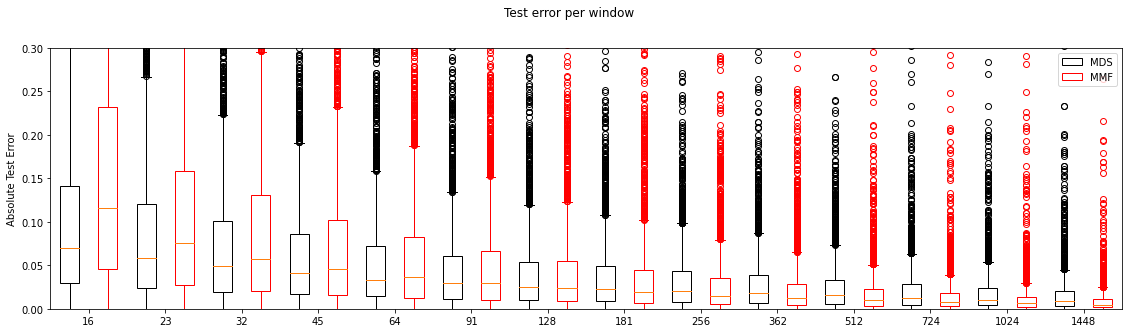

In [ ]:
win.Boxplots(ylim = (0,0.3))

### Class try 3

In [5]:
class Windowing:
  Slearners = np.array(['SVCl','SVCp', 'SVCr', 'SVCs','xTrs','GrBo','rFor','LogR','PaAg', 'Perc', 'Ridg', 'SGD','Bern','MuNo', 'KNei', 'MLP', 'dTre', 'xTre','linD','QuaD']).astype(str)

  def __init__(self, agg_dataframe):
    self.orig_dataframe = agg_dataframe
    self.results = {}
    
    # To pick what anchor points we want to analyse the distribution of data on each anchor point.
    train_size_count = self.orig_dataframe.groupby(['openmlid','size_train']).first().reset_index().groupby(['size_train'])[['size_train']].count().rename(columns = {'size_train':'Count'})
    display(train_size_count)
    self.train_size = train_size_count.index.values
    self.train_size_count = train_size_count.values.reshape(-1)
    
    # Turn dataframe into numpy
    self.learners = agg_dataframe['learner'].unique()
    self.datasets = agg_dataframe['openmlid'].unique()
    self.points = np.sort(agg_dataframe['size_train'].unique())

    name = ['openmlid', 'learner', 'size_train']
    multind = pd.MultiIndex.from_product([self.datasets,self.learners,self.points])

    _ = agg_dataframe.set_index(name)
    _ = _.reindex(multind)

    # shape is [dataset,learner,point]
    self.dataframe = _['score_test'].values.reshape(len(self.datasets), len(self.learners), len(self.points))

  def set_points(self, window_points, target_points, windows = False):
    
    self.windows = windows
    self.window_points = np.array([window_points]).reshape(-1) # To get right shape
    self.target_points = np.array([target_points]).reshape(-1)
    self.anchor_points = np.hstack((window_points,target_points[:-1]))
    self.s = len(self.anchor_points)
    self.results = {}

    
    # Grab the indices for numpy array
    indices_window = np.where(np.in1d(self.points, self.window_points))[0]
    indices_target = np.where(np.in1d(self.points, self.target_points))[0]

    # Grab the segment and the target values
    self.segment = self.dataframe[...,np.hstack((indices_window,indices_target[:-1]))]
    self.target = self.dataframe[...,indices_target]
    
    if self.windows:
      # Make all the windows, another dimension is added at the end for this [..., window]
      self.data = np.repeat(self.segment[...,None],self.segment.shape[2],-1)
      self.triu = np.triu_indices(self.segment.shape[2],1)
      self.data[...,self.triu[1],self.triu[0]] = np.nan
    else:
      self.data = np.repeat(self.segment[...,None],self.target.shape[2],-1)
      self.triu = np.triu_indices(self.target.shape[2],self.segment.shape[2]-self.target.shape[2]+1, self.segment.shape[2])
      self.data[...,self.triu[1],self.triu[0]] = np.nan    

  def MDS(self, k = 4):
    '''
    Applies MDS algorithm on all windows to retrieve the regression predictions.
    Saves the absolute error in the prediction. Also saves MDS version where you
    scale /adapt curves before picking them. Original version scales after picking
    '''
    data = np.copy(self.data)
    data[...,self.triu[1],self.triu[0]] = 0
    # weights = np.arange(1, self.s + 1) ** 2
    weights = (2**np.arange(self.s))[:,None]

    # We have the following shape [new dataset, meta dataset, learner, (point on curve),... extra dims]
    scalar = np.sum(weights * data[None]*data[:,None], axis = 3) / np.sum(weights*(data**2), axis = 2)[None]
    adapted_curves = scalar[:,:,:,None]*data
    adapted_target = scalar[...,None]*self.target[...,None,:]
    distance = np.sum((data-data[:,None])**2,axis = 3)
    distance_adapted = np.sum((adapted_curves - data)**2,axis = 3)

    distance = np.repeat(distance[...,None],len(self.target_points),axis = -1)
    distance_adapted = np.repeat(distance_adapted[...,None],len(self.target_points),axis = -1)

    # Remove curves that can't predict at target
    ind = np.isnan(self.target).nonzero()
    distance[:,ind[0],ind[1],...,ind[2]] = np.nan
    distance_adapted[:,ind[0],ind[1],...,ind[2]] = np.nan

    # So that it doesn't pick itself
    np.einsum('ii...->i...',distance)[...] = np.nan
    np.einsum('ii...->i...',distance_adapted)[...] = np.nan

    # Take k closest
    part_scale_after = np.argpartition(distance, k, axis = 1)[:,:k]
    part_scale_before = np.argpartition(distance_adapted, k, axis = 1)[:,:k,]
    k_closest_curves_scale_after = np.take_along_axis(adapted_target, part_scale_after, axis = 1)
    k_closest_curves_scale_before = np.take_along_axis(adapted_target, part_scale_before, axis = 1)

    # Predicted target is just the mean of the k closest curves at the target point
    prediction_scale_after = np.mean(k_closest_curves_scale_after,axis = 1)
    prediction_scale_before = np.mean(k_closest_curves_scale_before,axis = 1)
    
    target = np.copy(self.target)
    if self.windows:
      target = target[:,:,None]

    self.results['MDS'] = {}
    self.results['MDS']['test error'] = np.abs(prediction_scale_after - target)
    self.results['MDS']['(scale before) test error'] = np.abs(prediction_scale_before - target)
    self.results['MDS']['regression'] = prediction_scale_after
    self.results['MDS']['(scale before) regression'] = prediction_scale_before
    self.results['MDS']['k closest curves ID'] = part_scale_after
    self.results['MDS']['(scale before) k closest curves ID'] = part_scale_before
    self.results['MDS']['scalar'] = scalar
  
  def MMF(self, steps = 500):
    '''
    Applies MMF algorithm. Tensorized with pytorch so that it calculates quickly
    '''

    # Tensorise variables
    target = torch.tensor(self.target)
    data = torch.tensor(self.data)
    anchor_points = torch.tensor(self.anchor_points)
    weights = (2**torch.arange(self.s))[:,None]
    params = torch.tensor([0.5,1,1,-1])
    shp = np.hstack((np.array(data.shape[:2]),np.array(data.shape[3])))

    params = params.repeat(*shp,1)[:,:,None] # since len(dim[2]) = len(dim[3])

    params.requires_grad_()
    gr = torch.ones(*shp) # For .backward(), usually only takes a scalar but with this it doesn't need  to
    # Func to optimise

    def mmf_func(beta,x):
      x = x[:,None]
      return (beta[...,0] * beta[...,1] + beta[...,2] * x ** beta[...,3])/(beta[...,1] + x ** beta[...,3])
    optimizer = torch.optim.Adam([params], lr=0.1) # SGD did weird things, Adam works well!
    y = data
    nan = torch.isnan(y)
    y = torch.where(nan, torch.tensor(0.0), y)

    for i in range(steps):
      optimizer.zero_grad()
      # Sum over last dim, watch out with nan's maybe?
      out = mmf_func(params,anchor_points)
      out = torch.where(nan, torch.tensor(0.0), out)
      loss = (((out - y) ** 2)*weights).sum(2)
      # Each curve has separate .backward() with this
      loss.backward(gradient = gr)
      optimizer.step()

    params.requires_grad = False # To not waste computation
    target_points = torch.tensor(self.target_points)
    prediction = mmf_func(params,target_points)

    if self.windows:
      prediction = torch.einsum('...ij -> ...ji', prediction)
      target = target[:,:,None]

    self.results['MMF'] = {}
    self.results['MMF']['test error'] = (target - prediction).abs().numpy()
    self.results['MMF']['parameters'] = params.numpy()

  def Last(self):

    target = np.copy(self.target)
    if self.windows:
      prediction = self.data[:,:,np.arange(self.s),np.arange(self.s)]
      target = target[:,:,None]
    else:
      prediction = self.data[:,:,-1]
    
    self.results['Last'] = {}
    self.results['Last']['test error'] = np.abs(prediction[...,None] - target)

  def _returnIDs(self, dataset = slice(None),  learner = slice(None), window = slice(None), target = slice(None)):
    
    if type(window) == str:
      windowID = np.where(self.anchor_points.astype(str) == window)[0][0]
    else:
      windowID = window

    if type(learner) == str:
      learnerID = np.where(self.Slearners == learner)[0][0]
    else:
      learnerID = learner
    
    if type(dataset) == str:
      datasetID = np.where(self.datasets.astype(str) == dataset)[0][0]
    else: 
      datasetID = dataset
    
    if type(target) == str:
      targetID = np.where(self.target_points.astype(str) == target)[0][0]
    else:
      targetID = target
    
    return datasetID, learnerID, windowID, targetID

  def PlotCurveAndPrediction(self, dataset, learner, window, target, scaled = True, ylabel = None, xlabel = None, title = None):
    '''
    Given the learner, dataset and window this will return a scatter plot of the
    actual curve, the MMF predicted curve, the k-nearest curves (scaled) and the
    MDS prediction. It even plots the missing anchor points that are not included
    when tensorizing the calculations.
    '''
    fig,ax = plt.subplots(1,1,figsize = [6.4,4.8])
    datasetID, learnerID, windowID, targetID = self._returnIDs(dataset,learner,window,target)
    
    if title:
      fig.suptitle(title, y=0.9)
    if ylabel:
      ax.set_ylabel(ylabel)
    if xlabel:
      ax.set_xlabel(xlabel)                                                
    
    # Curve points, we also take the regularised points and put them back in to see
    ax.scatter(self.anchor_points[:windowID+1],self.segment[datasetID,learnerID][:windowID+1], color = 'blue', marker = 'o')
    ax.scatter(self.target_points[targetID], self.target[datasetID,learnerID, targetID],color = 'red')
    
    stopID = np.where(self.points == self.target_points[targetID])[0][0]
    ax.scatter(self.points[:stopID], self.dataframe[datasetID, learnerID, :stopID], color = 'blue', marker = 'x')

    # MMF prediction plot
    x = np.linspace(self.anchor_points[0],self.target_points[targetID],10000)
    a,b,c,d = self.results['MMF']['parameters'][datasetID,learnerID, 0, windowID]
    fun = lambda x: (a * b + c * x ** d)/(b + x ** d)
    ax.plot(x,fun(x))

    # MDS regression k-nearest neighbors, also put the regularised points back in
    knn = self.results['MDS']['k closest curves ID'][datasetID,:,learnerID,windowID,targetID]

    for k in knn:
      c = self.results['MDS']['scalar'][datasetID, k, learnerID, windowID]
      ax.scatter(self.points[:stopID+1], c*self.dataframe[k, learnerID, :stopID+1], s = 5)
    
    # MDS regression prediction
    ax.scatter(self.target_points[targetID], self.results['MDS']['regression'][datasetID, learnerID, windowID, targetID], color = 'red', marker = 'x')

    # Last One prediction
    ax.plot(x,np.full(x.shape, self.segment[datasetID,learnerID,windowID]), color = 'green')

  def Boxplots(self, dataset = slice(None),  learner = slice(None), window = slice(None), target = slice(None), xaxis = 'window', ylim =(0,1), figsize = (3,1), ylabel = 'Absolute Test Error', title = None):
    datasetID, learnerID, windowID, targetID = self._returnIDs(dataset,learner,window,target)
    plots = {}
    if xaxis == 'dataset':
      ind = np.arange(len(self.datasets))[datasetID]
      for key in self.results.keys():
        plots[key] = {str(self.datasets[i]):self.results[key]['test error'][i, learnerID, windowID, targetID] for i in ind}
      xlabel = 'ID of dataset'

    if xaxis == 'learner':
      ind = np.arange(len(self.Slearners))[learnerID]
      for key in self.results.keys():
        plots[key] = {self.Slearners[i]:self.results[key]['test error'][datasetID, i, windowID, targetID] for i in ind}
      xlabel = 'Abbreviated name of learner'

    if xaxis == 'window':
      ind = np.arange(len(self.anchor_points))[windowID]
      for key in self.results.keys():
        plots[key] = {str(self.anchor_points[i]):self.results[key]['test error'][datasetID, learnerID, i, targetID] for i in ind}
      xlabel = 'Value of last anchor point in the window'

    if xaxis == 'target':
      ind = np.arange(len(self.target_points))[targetID]
      for key in self.results.keys():
        plots[key] = {str(self.target_points[i]):self.results[key]['test error'][datasetID, learnerID, windowID, i] for i in ind}
      xlabel = 'Value of anchor point at which the prediction hapens'

    if not title:
        title = f'Test error per {xaxis}'
        sup = ' for '
        for val,name in [(dataset,'dataset(s)'), (learner,'learner(s)'), (window,'last point in window(s)'), (target, 'target(s)')]:
          if val == slice(None):
            continue
          if name == 'dataset(s)':
            val = self.datasets[datasetID]
          if name == 'learner(s)':
            val = self.Slearners[learnerID]
          if name == 'last point in window(s)':
            val = self.anchor_points[windowID]
          if name == 'target(s)':
            val = self.target_points[targetID]
          sup += f'{name}: {val}, '
        sup = sup[0:-2]
        if sup != ' fo': title += sup
    Boxplots(plots, ylabel = ylabel, xlabel = xlabel, ylim = ylim,figsize = figsize, title = title)


#### Test

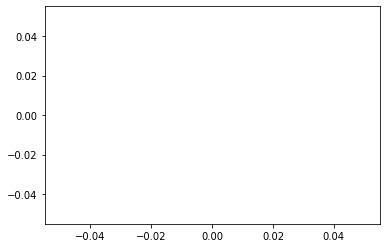

In [ ]:
plt.plot(0,0)

In [6]:
Win = Windowing(aggCurves)

,Count
size_train,
16,245
23,246
32,246
40,1
45,244
...,...
1048576,2
1482910,1
1486391,1


In [7]:
reg_list = Win.train_size[Win.train_size_count > 100]

Win.set_points(list(reg_list[:14]),list(reg_list[14:]), True)

In [8]:
Win.MDS()
err = Win.results['MDS']['test error']

In [9]:
Win.MMF()
err2 = Win.results['MMF']['test error']

In [10]:
Win.Last()
err3 = Win.results['Last']['test error']

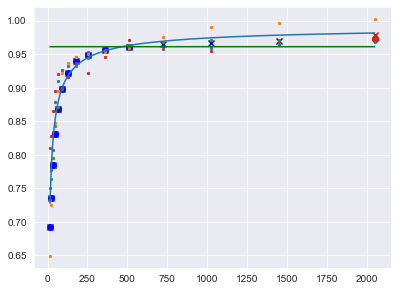

In [11]:
Win.PlotCurveAndPrediction(0,0,10,0)

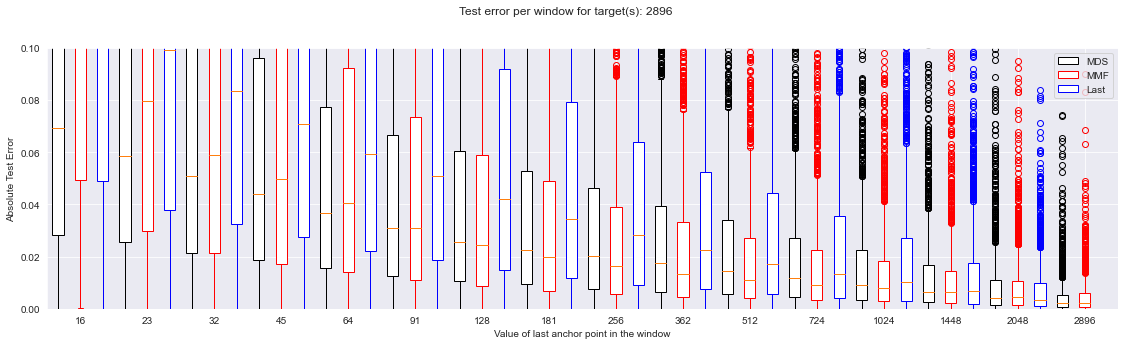

In [14]:
Win.Boxplots(target = -2,ylim = (0,0.1),figsize = (3,1))

In [19]:
err.shape

(248, 20, 16, 3)

In [40]:
err[1,0]

array([[0.15074429, 0.14953362, 0.15035168],
       [0.14597327, 0.14466902, 0.14561557],
       [0.04519921, 0.04216133, 0.03859102],
       [0.07564402, 0.07413625, 0.07241188],
       [0.06261821, 0.060978  , 0.05920665],
       [0.03009378, 0.01504542, 0.01186978],
       [0.00033778, 0.01383888, 0.01690939],
       [0.02080926, 0.03348142, 0.03674696],
       [0.04716365, 0.04987758, 0.05320584],
       [0.02531152, 0.02604434, 0.02822036],
       [0.0257799 , 0.02644213, 0.028506  ],
       [0.01896663, 0.01949312, 0.02137142],
       [0.01281417, 0.01321223, 0.0149157 ],
       [0.01177758, 0.01211242, 0.01371731],
       [0.00543548, 0.00565042, 0.00709105],
       [0.0024874 , 0.00263588, 0.00398334]])

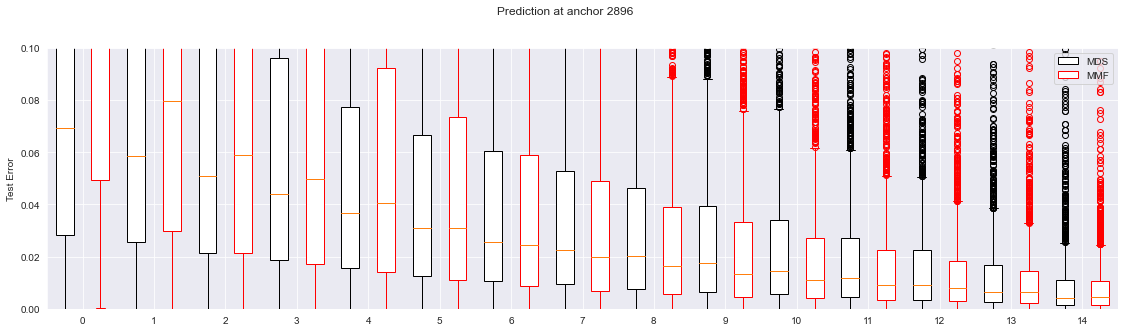

In [36]:
# Weighting system of (2**np.arange(self.s))[:,None] for both
j = 0

plots = {'MDS': {str(i): err[:,:,i,1] for i in range(15)},'MMF':{str(i): err2[:,:,i,1] for i in range(15)}}


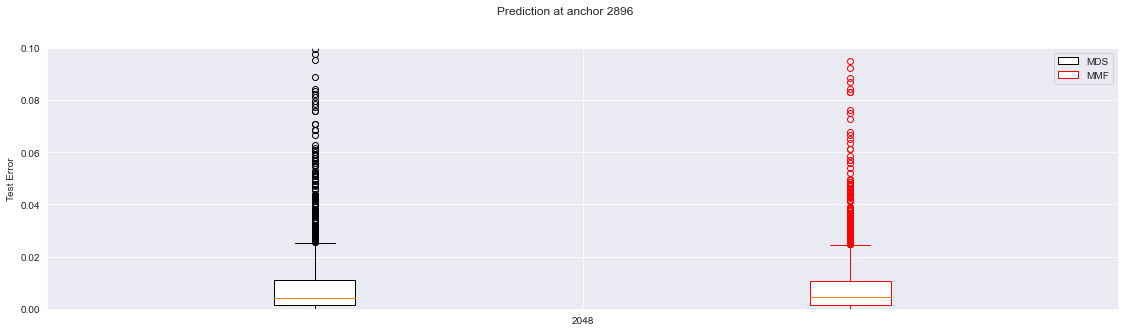

In [34]:
# Weighting system of np.arange(1, self.s + 1) ** 2 for MDS and (2**np.arange(self.s))[:,None] for MMF
i = 14
j = 1
plots = {'MDS': {str(Win.anchor_points[i]): err[...,i,j]}, 'MMF':{str(Win.anchor_points[i]): err2[...,i,j]}}
Boxplots(plots, ylim = (0,0.1),figsize = (3,1), ylabel = 'Test Error',title= f'Prediction at anchor {Win.target_points[j]}')

### Class Try 4
This time we only have n points in our window (n = 5 default). We always move those points right, so our window always has n points.

We now give the anchor points and it takes all windows sieze n and possible target points. It does a sliding window.

In [ ]:
from numpy.lib.stride_tricks import sliding_window_view
class windowing:
  Slearners = np.array(['SVCl','SVCp', 'SVCr', 'SVCs','xTrs','GrBo','rFor','LogR','PaAg', 'Perc', 'Ridg', 'SGD','Bern','MuNo', 'KNei', 'MLP', 'dTre', 'xTre','linD','QuaD']).astype(str)

  def __init__(self, agg_dataframe):
    self.orig_dataframe = agg_dataframe
    self.results = {}
    
    # To pick what anchor points we want to analyse the distribution of data on each anchor point.
    train_size_count = self.orig_dataframe.groupby(['openmlid','size_train']).first().reset_index().groupby(['size_train'])[['size_train']].count().rename(columns = {'size_train':'Count'})
    display(train_size_count)
    self.train_size = train_size_count.index.values
    self.train_size_count = train_size_count.values.reshape(-1)
    
    # Turn dataframe into numpy
    self.learners = agg_dataframe['learner'].unique()
    self.datasets = agg_dataframe['openmlid'].unique()
    self.points = np.sort(agg_dataframe['size_train'].unique())

    name = ['openmlid', 'learner', 'size_train']
    multind = pd.MultiIndex.from_product([self.datasets,self.learners,self.points])

    _ = agg_dataframe.set_index(name)
    _ = _.reindex(multind)

    # shape is [dataset,learner,point]
    self.dataframe = _['score_test'].values.reshape(len(self.datasets), len(self.learners), len(self.points))

  def set_points(self, anchor_points, window_size):
    
    self.window_size = window_size
    self.anchor_points = np.array([anchor_points]).reshape(-1) # To get right shape
    self.target_points = self.anchor_points[window_size:]
    self.s = len(self.anchor_points)
    self.results = {}

    
    # Grab the indices for numpy array
    indices = np.where(np.in1d(self.points, self.anchor_points))[0]

    # Grab the segment values
    self.segment = self.dataframe[...,indices]
    
    # Split all possible windows and target points
    # Use the sliding_window_view() function to create a view of the array with sliding windows
    self.target = self.segment[:,:,window_size:]
    self.data = np.copy(sliding_window_view(self.segment[:,:,:-1], window_size, axis = -1))
    self.data = np.einsum('ijkl -> ijlk',self.data)


  def MDS(self, k = 4):
    '''
    Applies MDS algorithm on all windows to retrieve the regression predictions.
    Saves the absolute error in the prediction. Also saves MDS version where you
    scale /adapt curves before picking them. Original version scales after picking
    '''
    data = np.copy(self.data)
    weights = (2**np.arange(self.window_size))[:,None]

    # We have the following shape [new dataset, meta dataset, learner, (point on curve),... extra dims]scalar = np.sum(weights * data[None]*data[:,None], axis = 3) / np.sum(weights*(data**2), axis = 2)[None]
    scalar = np.sum(weights * data[None]*data[:,None], axis = 3) / np.sum(weights*(data**2), axis = 2)[None]
    adapted_curves = scalar[:,:,:,None]*data
    adapted_target = scalar[...,None]*self.target[...,None,:]
    distance = np.sum((data-data[:,None])**2,axis = 3)
    distance_adapted = np.sum((adapted_curves - data)**2,axis = 3)

    # Expand for next step
    distance = np.repeat(distance[...,None],self.target.shape[-1],axis = -1)
    distance_adapted = np.repeat(distance_adapted[...,None],self.target.shape[-1],axis = -1)

    # Remove curves that can't predict at target
    ind = np.isnan(self.target).nonzero()
    distance[:,ind[0],ind[1],...,ind[2]] = np.nan
    distance_adapted[:,ind[0],ind[1],...,ind[2]] = np.nan

    # So that it doesn't pick itself
    np.einsum('ii...->i...',distance)[...] = np.nan
    np.einsum('ii...->i...',distance_adapted)[...] = np.nan

    # Take k closest
    part_scale_after = np.argpartition(distance, k, axis = 1)[:,:k]
    part_scale_before = np.argpartition(distance_adapted, k, axis = 1)[:,:k,]
    k_closest_curves_scale_after = np.take_along_axis(adapted_target, part_scale_after, axis = 1)
    k_closest_curves_scale_before = np.take_along_axis(adapted_target, part_scale_before, axis = 1)

    # Predicted target is just the mean of the k closest curves at the target point
    prediction_scale_after = np.mean(k_closest_curves_scale_after,axis = 1)
    prediction_scale_before = np.mean(k_closest_curves_scale_before,axis = 1)
    
    # Remove predictions for anchor points that are in front of the window
    ind = np.triu_indices(len(self.target_points),1)
    prediction_scale_after[:,:,ind[1],ind[0]] = np.nan
    prediction_scale_before[:,:,ind[1],ind[0]] = np.nan

    self.results['MDS'] = {}
    self.results['MDS']['test error'] = np.abs(prediction_scale_after - self.target[:,:,None])
    self.results['MDS']['(scale before) test error'] = np.abs(prediction_scale_before - self.target[:,:,None])
    self.results['MDS']['regression'] = prediction_scale_after
    self.results['MDS']['(scale before) regression'] = prediction_scale_before
    self.results['MDS']['k closest curves ID'] = part_scale_after
    self.results['MDS']['(scale before) k closest curves ID'] = part_scale_before
    self.results['MDS']['scalar'] = scalar
  
  def MMF(self, steps = 500):
    '''
    Applies MMF algorithm. Tensorized with pytorch so that it calculates quickly
    '''

    # Tensorise variables
    target = torch.tensor(self.target)
    data = torch.tensor(self.data)
    anchor_points = torch.tensor(self.anchor_points)
    weights = (2**torch.arange(self.s))[:,None]
    params = torch.tensor([0.5,1,1,-1])
    shp = np.hstack((np.array(data.shape[:2]),np.array(data.shape[3])))

    params = params.repeat(*shp,1)[:,:,None] # since len(dim[2]) = len(dim[3])

    params.requires_grad_()
    gr = torch.ones(*shp) # For .backward(), usually only takes a scalar but with this it doesn't need  to
    # Func to optimise

    def mmf_func(beta,x):
      x = x[:,None]
      return (beta[...,0] * beta[...,1] + beta[...,2] * x ** beta[...,3])/(beta[...,1] + x ** beta[...,3])
    optimizer = torch.optim.Adam([params], lr=0.1) # SGD did weird things, Adam works well!
    y = data
    nan = torch.isnan(y)
    y = torch.where(nan, torch.tensor(0.0), y)

    for i in range(steps):
      optimizer.zero_grad()
      # Sum over last dim, watch out with nan's maybe?
      out = mmf_func(params,anchor_points)
      out = torch.where(nan, torch.tensor(0.0), out)
      loss = (((out - y) ** 2)*weights).sum(2)
      # Each curve has separate .backward() with this
      loss.backward(gradient = gr)
      optimizer.step()

    params.requires_grad = False # To not waste computation
    target_points = torch.tensor(self.target_points)
    prediction = mmf_func(params,target_points)

    if self.windows:
      prediction = torch.einsum('...ij -> ...ji', prediction)
      target = target[:,:,None]

    self.results['MMF'] = {}
    self.results['MMF']['test error'] = (target - prediction).abs().numpy()
    self.results['MMF']['parameters'] = params.numpy()

  def Last(self):

    target = np.copy(self.target)
    if self.windows:
      prediction = self.data[:,:,np.arange(self.s),np.arange(self.s)]
      target = target[:,:,None]
    else:
      prediction = self.data[:,:,-1]
    
    self.results['Last'] = {}
    self.results['Last']['test error'] = np.abs(prediction[...,None] - target)

  def _returnIDs(self, dataset = slice(None),  learner = slice(None), window = slice(None), target = slice(None)):
    
    if type(window) == str:
      windowID = np.where(self.anchor_points.astype(str) == window)[0][0]
    else:
      windowID = window

    if type(learner) == str:
      learnerID = np.where(self.Slearners == learner)[0][0]
    else:
      learnerID = learner
    
    if type(dataset) == str:
      datasetID = np.where(self.datasets.astype(str) == dataset)[0][0]
    else: 
      datasetID = dataset
    
    if type(target) == str:
      targetID = np.where(self.target_points.astype(str) == target)[0][0]
    else:
      targetID = target
    
    return datasetID, learnerID, windowID, targetID

  def PlotCurveAndPrediction(self, dataset, learner, window, target, scaled = True, ylabel = None, xlabel = None, title = None):
    '''
    Given the learner, dataset and window this will return a scatter plot of the
    actual curve, the MMF predicted curve, the k-nearest curves (scaled) and the
    MDS prediction. It even plots the missing anchor points that are not included
    when tensorizing the calculations.
    '''
    fig,ax = plt.subplots(1,1,figsize = [6.4,4.8])
    datasetID, learnerID, windowID, targetID = self._returnIDs(dataset,learner,window,target)
    
    if title:
      fig.suptitle(title, y=0.9)
    if ylabel:
      ax.set_ylabel(ylabel)
    if xlabel:
      ax.set_xlabel(xlabel)                                                
    
    # Curve points, we also take the regularised points and put them back in to see
    ax.scatter(self.anchor_points[:windowID+1],self.segment[datasetID,learnerID][:windowID+1], color = 'blue', marker = 'o')
    ax.scatter(self.target_points[targetID], self.target[datasetID,learnerID, targetID],color = 'red')
    
    stopID = np.where(self.points == self.target_points[targetID])[0][0]
    ax.scatter(self.points[:stopID], self.dataframe[datasetID, learnerID, :stopID], color = 'blue', marker = 'x')

    # MMF prediction plot
    x = np.linspace(self.anchor_points[0],self.target_points[targetID],10000)
    a,b,c,d = self.results['MMF']['parameters'][datasetID,learnerID, 0, windowID]
    fun = lambda x: (a * b + c * x ** d)/(b + x ** d)
    ax.plot(x,fun(x))

    # MDS regression k-nearest neighbors, also put the regularised points back in
    knn = self.results['MDS']['k closest curves ID'][datasetID,:,learnerID,windowID,targetID]

    for k in knn:
      c = self.results['MDS']['scalar'][datasetID, k, learnerID, windowID]
      ax.scatter(self.points[:stopID+1], c*self.dataframe[k, learnerID, :stopID+1], s = 5)
    
    # MDS regression prediction
    ax.scatter(self.target_points[targetID], self.results['MDS']['regression'][datasetID, learnerID, windowID, targetID], color = 'red', marker = 'x')

    # Last One prediction
    ax.plot(x,np.full(x.shape, self.segment[datasetID,learnerID,windowID]), color = 'green')

  def Boxplots(self, dataset = slice(None),  learner = slice(None), window = slice(None), target = slice(None), xaxis = 'window', ylim =(0,1), figsize = (3,1), ylabel = 'Absolute Test Error', title = None):
    datasetID, learnerID, windowID, targetID = self._returnIDs(dataset,learner,window,target)
    plots = {}
    if xaxis == 'dataset':
      ind = np.arange(len(self.datasets))[datasetID]
      for key in self.results.keys():
        plots[key] = {str(self.datasets[i]):self.results[key]['test error'][i, learnerID, windowID, targetID] for i in ind}
      xlabel = 'ID of dataset'

    if xaxis == 'learner':
      ind = np.arange(len(self.Slearners))[learnerID]
      for key in self.results.keys():
        plots[key] = {self.Slearners[i]:self.results[key]['test error'][datasetID, i, windowID, targetID] for i in ind}
      xlabel = 'Abbreviated name of learner'

    if xaxis == 'window':
      windows = self.anchor_points[self.window_size-1:-1]
      ind = np.arange(len(windows))[windowID]
      for key in self.results.keys():
        plots[key] = {str(windows[i]):self.results[key]['test error'][datasetID, learnerID, i, targetID] for i in ind}
      xlabel = 'Value of last anchor point in the window'

    if xaxis == 'target':
      ind = np.arange(len(self.target_points))[targetID]
      for key in self.results.keys():
        plots[key] = {str(self.target_points[i]):self.results[key]['test error'][datasetID, learnerID, windowID, i] for i in ind}
      xlabel = 'Value of anchor point at which the prediction hapens'

    if not title:
        title = f'Test error per {xaxis}'
        sup = ' for '
        for val,name in [(dataset,'dataset(s)'), (learner,'learner(s)'), (window,'last point in window(s)'), (target, 'target(s)')]:
          if val == slice(None):
            continue
          if name == 'dataset(s)':
            val = self.datasets[datasetID]
          if name == 'learner(s)':
            val = self.Slearners[learnerID]
          if name == 'last point in window(s)':
            val = self.anchor_points[windowID]
          if name == 'target(s)':
            val = self.target_points[targetID]
          sup += f'{name}: {val}, '
        sup = sup[0:-2]
        if sup != ' fo': title += sup
    Boxplots(plots, ylabel = ylabel, xlabel = xlabel, ylim = ylim,figsize = figsize, title = title)


#### Test

In [ ]:
# Tensorise variables
target = torch.tensor(win.target)
data = torch.tensor(win.data)
anchor_points = torch.tensor(win.anchor_points[:-1]).unfold(0,win.window_size,1)
weights = (2**torch.arange(win.window_size))[:,None]

tensor([[  16,   23,   32,   45,   64],
        [  23,   32,   45,   64,   91],
        [  32,   45,   64,   91,  128],
        [  45,   64,   91,  128,  181],
        [  64,   91,  128,  181,  256],
        [  91,  128,  181,  256,  362],
        [ 128,  181,  256,  362,  512],
        [ 181,  256,  362,  512,  724],
        [ 256,  362,  512,  724, 1024],
        [ 362,  512,  724, 1024, 1448],
        [ 512,  724, 1024, 1448, 2048],
        [ 724, 1024, 1448, 2048, 2896]])

In [ ]:
# Tensorise variables
target = torch.tensor(win.target)
data = torch.tensor(win.data)
anchor_points = torch.tensor(win.anchor_points[:-1])
weights = (2**torch.arange(win.window_size))[:,None]
params = torch.tensor([0.5,1,1,-1])
shp = np.hstack((np.array(data.shape[:2]),np.array(data.shape[3])))

params = params.repeat(*shp,1)[:,:,None] # since len(dim[2]) = len(dim[3])

params.requires_grad_()
gr = torch.ones(*shp) # For .backward(), usually only takes a scalar but with this it doesn't need  to
# Func to optimise

def mmf_func(beta,x):
  x = x[:,None]
  return (beta[...,0] * beta[...,1] + beta[...,2] * x ** beta[...,3])/(beta[...,1] + x ** beta[...,3])
optimizer = torch.optim.Adam([params], lr=0.1) # SGD did weird things, Adam works well!
y = data
nan = torch.isnan(y)
y = torch.where(nan, torch.tensor(0.0), y)

for i in range(steps):
  optimizer.zero_grad()
  # Sum over last dim, watch out with nan's maybe?
  out = mmf_func(params,anchor_points)
  out = torch.where(nan, torch.tensor(0.0), out)
  loss = (((out - y) ** 2)*weights).sum(2)
  # Each curve has separate .backward() with this
  loss.backward(gradient = gr)
  optimizer.step()

params.requires_grad = False # To not waste computation
target_points = torch.tensor(self.target_points)
prediction = mmf_func(params,target_points)

if self.windows:
  prediction = torch.einsum('...ij -> ...ji', prediction)
  target = target[:,:,None]

self.results['MMF'] = {}
self.results['MMF']['test error'] = (target - prediction).abs().numpy()
self.results['MMF']['parameters'] = params.numpy()


In [ ]:
b = np.triu_indices(12,1)
a = np.full((12,12),1)
a[b[1],b[0]] = 0
a[0]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
win.segment[2,3]

array([0.4644912, 0.47262  , 0.46576  , 0.4799864, 0.4769392, 0.4627152,
       0.4971368, 0.521648 , 0.580192 ,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan])

In [ ]:
prediction_scale_after[2,3]

array([[0.48053105, 0.47391853, 0.46534211, 0.46016802, 0.45506187,
        0.44914134, 0.44412557, 0.43897752, 0.43320393, 0.43193708,
        0.50695034, 0.49151767],
       [       nan, 0.45849506, 0.4449392 , 0.41286874, 0.40214438,
        0.38982547, 0.43304363, 0.42942656, 0.42519939, 0.42622127,
        0.50030828, 0.48528855],
       [       nan,        nan, 0.47447095, 0.45064746, 0.44276003,
        0.43302569, 0.47674562, 0.47422026, 0.47061666, 0.47250204,
        0.52170251, 0.5053902 ],
       [       nan,        nan,        nan, 0.5071757 , 0.50888673,
        0.50654846, 0.50610501, 0.50629412, 0.51684031, 0.54215149,
        0.54294467, 0.54500405],
       [       nan,        nan,        nan,        nan, 0.56129079,
        0.57691153, 0.58105357, 0.58980641, 0.58401719, 0.59841325,
        0.58396703, 0.57846317],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,

In [ ]:
win = windowing(aggCurves)

,Count
size_train,
16,245
23,246
32,246
40,1
45,244
...,...
1048576,2
1482910,1
1486391,1


In [ ]:
reg_list = win.train_size[win.train_size_count > 100]

win.set_points(list(reg_list), 5)

In [ ]:
win.results['MDS']['test error'].shape

(248, 20, 12, 12)

In [ ]:
win.MDS()

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


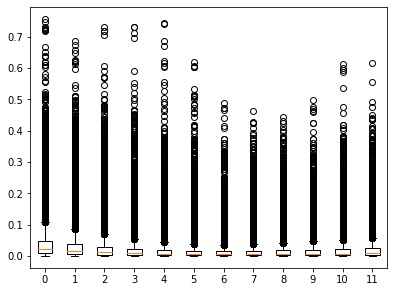

In [ ]:
plot = {i: win.results['MDS']['test error'][...,i,:] for i in range(12)}
Boxplots(plot)

In [ ]:
win.target.shape

(248, 20, 12)

In [ ]:
data = np.copy(win.data)
weights = (2**np.arange(win.window_size))[:,None]

# We have the following shape [new dataset, meta dataset, learner, (point on curve),... extra dims]
scalar = np.sum(weights * data[None]*data[:,None], axis = 3) / np.sum(weights*(data**2), axis = 2)[None]
adapted_curves = scalar[:,:,:,None]*data
adapted_target = scalar[...,None]*self.target[...,None,:]
distance = np.sum((data-data[:,None])**2,axis = 3)
distance_adapted = np.sum((adapted_curves - data)**2,axis = 3)

# Expand for next step
distance = np.repeat(distance[...,None],len(self.target_points),axis = -1)
distance_adapted = np.repeat(distance_adapted[...,None],len(self.target_points),axis = -1)

# Remove curves that can't predict at target
ind = np.isnan(self.target).nonzero()
distance[:,ind[0],ind[1],...,ind[2]] = np.nan
distance_adapted[:,ind[0],ind[1],...,ind[2]] = np.nan

# So that it doesn't pick itself
np.einsum('ii...->i...',distance)[...] = np.nan
np.einsum('ii...->i...',distance_adapted)[...] = np.nan

# Take k closest
part_scale_after = np.argpartition(distance, k, axis = 1)[:,:k]
part_scale_before = np.argpartition(distance_adapted, k, axis = 1)[:,:k,]
k_closest_curves_scale_after = np.take_along_axis(adapted_target, part_scale_after, axis = 1)
k_closest_curves_scale_before = np.take_along_axis(adapted_target, part_scale_before, axis = 1)

# Predicted target is just the mean of the k closest curves at the target point
prediction_scale_after = np.mean(k_closest_curves_scale_after,axis = 1)
prediction_scale_before = np.mean(k_closest_curves_scale_before,axis = 1)

target = np.copy(self.target)
if self.windows:
  target = target[:,:,None]

self.results['MDS'] = {}
self.results['MDS']['test error'] = np.abs(prediction_scale_after - target)
self.results['MDS']['(scale before) test error'] = np.abs(prediction_scale_before - target)
self.results['MDS']['regression'] = prediction_scale_after
self.results['MDS']['(scale before) regression'] = prediction_scale_before
self.results['MDS']['k closest curves ID'] = part_scale_after
self.results['MDS']['(scale before) k closest curves ID'] = part_scale_before
self.results['MDS']['scalar'] = scalar

In [ ]:
win.data.shape

(248, 20, 5, 12)

In [ ]:
win.targets.shape

(248, 20, 12)

## Windowing

In [ ]:
win = Windowing(aggCurves, points = [16,   23,   32,   45,   64,   91,  128,  181,  256,  362,  512,
        724, 1024, 1448])

TypeError: ignored

In [ ]:
steps = 500
points = [16,   23,   32,   45,   64,   91,  128,  181,  256,  362,  512,
        724, 1024, 1448]

start = time.time()
# We take every possible point that we go through. We repeat this n times
# and set [i:] = np.nan each time as for that repetition it doesn't get the later curve info.
# n is the total points we looks through
data = np.repeat(win.segment[None], win.segment.shape[-1], axis=0)
ind = np.triu_indices(data.shape[-1],1)
data[ind[0],...,ind[1]] = np.nan

# Tensorise variables
target = np.repeat(win.target[None], win.segment.shape[-1], axis=0)
target = torch.tensor(target)
data = torch.tensor(data)
segment = torch.tensor(win.segment)
points = torch.tensor(win.points)[None,None]

weights = (2**torch.arange(win.s))
params = torch.tensor([0.5,1,1,-1])
params = params.repeat(*target.shape,1)[...,None]
params.requires_grad_()
gr = torch.ones(target.shape) # For .backward(), usually only takes a scalar but with this it doesn't need  to

# Func to optimise
def mmf_func(beta,x):
  return (beta[...,0,:] * beta[...,1,:] + beta[...,2,:] * x ** beta[...,3,:])/(beta[...,1,:] + x ** beta[...,3,:])

optimizer = torch.optim.Adam([params], lr=0.1) # SGD did weird things, Adam works well!
y = data
nan = torch.isnan(y)
y = torch.where(nan, torch.tensor(0.0), y)
for i in range(steps):
  optimizer.zero_grad()
  # Sum over last dim, watch out with nan's maybe?

  out = mmf_func(params,points)
  out = torch.where(nan, torch.tensor(0.0), out)
  loss = (((out - y) ** 2)*weights).sum(-1)
  # Each curve has separate .backward() with this
  loss.backward(gradient = gr)
  optimizer.step()

params.requires_grad = False # To not waste computation
target_point = torch.tensor([win.target_point])[None,None]
prediction = mmf_func(params,target_point).squeeze()

trainError = (segment - mmf_func(params,points)).abs()
testError = (target - prediction).abs()
print(np.abs(start-time.time()))

30.341261625289917


In [ ]:
win.reg_size_train[:-2]

array([  16,   23,   32,   45,   64,   91,  128,  181,  256,  362,  512,
        724, 1024, 1448, 2048])

In [ ]:
np.where(win.Slearners == 'SVCs')

(array([3]),)

In [ ]:
plots1 = {str(win.reg_size_train[i]):testError.numpy()[i] for i in range(14)}
Boxplots(plots1, ylim =(0,1),figsize = (2,1))

AttributeError: ignored

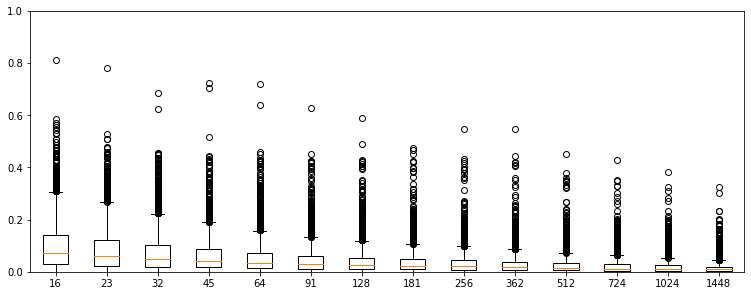

In [ ]:
plots2 = {str(win.reg_size_train[i]): mdsreg_errors[i] for i in range(14)}
Boxplots(plots2, ylim =(0,1),figsize = (2,1))

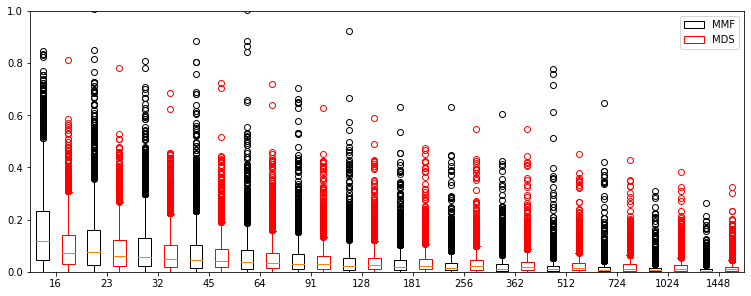

In [ ]:
plots = {'MMF':plots1,'MDS':plots2}
Boxplots(plots, ylim =(0,1),figsize = (2,1), ylabel = 'Test Error')

In [ ]:
mdsreg_errors = []
for i in range(points.shape[-1]):
  win = Windowing(aggCurves, points = list(win.reg_size_train[:i+1]))
  win.MDS()
  mdsreg_error = win.results['MDS regression']['test error']
  mdsreg_errors.append(mdsreg_error)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:130: RuntimeWarning: Mean of empty slice


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:130: RuntimeWarning: Mean of empty slice


49.726258754730225


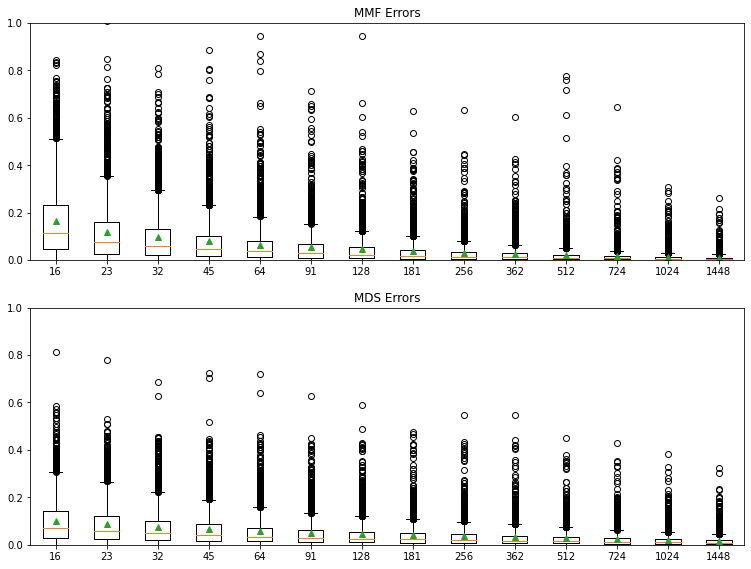

In [ ]:
start = time.time()
win.windowing(16,1448)
print(np.abs(start-time.time()))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:130: RuntimeWarning: Mean of empty slice


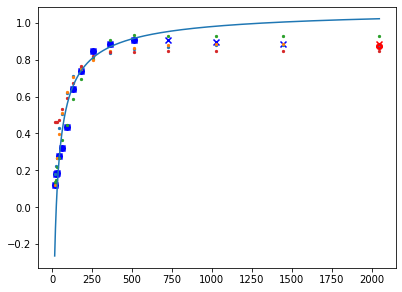

In [ ]:
last = 512
points = list(win.reg_size_train[:np.where(win.reg_size_train == last)[0][0]+1])
win = Windowing(aggCurves, points)
win.MDS()
win.MMF()
win.scatter('SVCs',4)

## Testing MMF
From the tests it looks like Powell and Nelder-Mead are the best method. We test on points = [16, 23, 32, 45, 64], for these the error is much bettern than MDS so we assume that with bigger window this error woudl only get even better.

### Parameter optimization MMF

In [ ]:
# We try these methods in scipy.optimize.minimize (lm is what they use in paper and is for scipy.optimize.least_squares)
methods = ['default', 'Powell', 'lm','Nelder-Mead']
points = [16, 23, 32, 45, 64]
ptarget = [2048]
target_point = 2048
Curves = RegularizeDF(aggCurves,points+ptarget)
dataframe = Curves


testErrors = []
trainErrors = []
for method in methods:
  ans, penalty, success, params, trainError, testError = MMFbaseline(Curves, points, target_point, method)
  testErrors.append(testError)
  trainErrors.append(trainError)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/_minimize.py:542: RuntimeWarning: Method Powell cannot handle constraints.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:297: RuntimeWarning: overflow encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:297: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/scipy/optimize/_minimize.py:542: RuntimeWarning: Method Nelder-Mead cannot handle constraints.
  RuntimeWarning)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:118: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:119: RuntimeWarning: Mean of empty slice


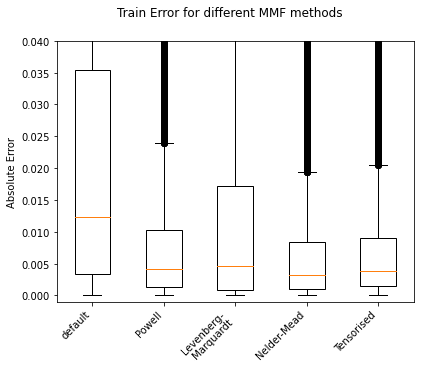

In [ ]:
# Powell vs default vs lm vs Nelder-Mead
default, Powell, lm, NM = np.array(trainErrors[0]),np.array(trainErrors[1]),np.array(trainErrors[2]),np.array(trainErrors[3])
win = Windowing(aggCurves)
win.MMF()
win.MDS()

#boxplot, looks like Powell is pretty good. Nelder-Mead is basically the same
#The default was pretty bad
plots = {'default': default, 'Powell': Powell, 'Levenberg-\n Marquardt': lm, 'Nelder-Mead': NM, 'Tensorised': win.results['MMF']['train error']}
Boxplots(plots, 'Absolute Error', ylim = (-0.001,0.04), xrot = True, title = 'Train Error for different MMF methods')

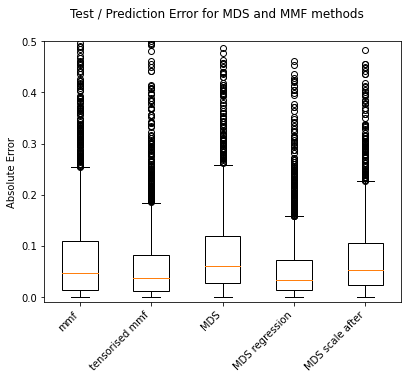

In [ ]:
plots = {'mmf': testError , 'tensorised mmf': win.results['MMF']['test error'], 'MDS': win.results['MDS']['test error'],'MDS regression': win.results['MDS regression']['test error'],'MDS scale after': win.results['MDS scale after']['test error']}
Boxplots(plots, 'Absolute Error', xrot = True, ylim = (-0.01,0.5), title = 'Test / Prediction Error for MDS and MMF methods')

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


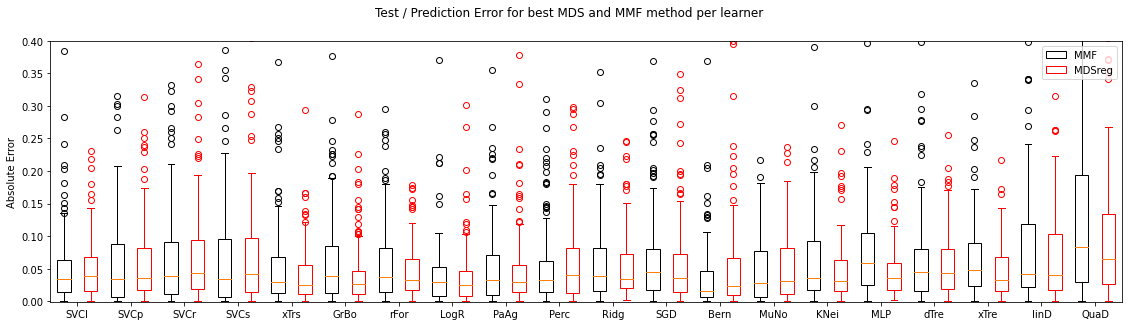

In [ ]:
plots = {'MMF': {Slearners[i]:win.results['MMF']['test error'][:,i] for i in range(len(learners))}, 'MDSreg': {Slearners[i]:win.results['MDS regression']['test error'][:,i] for i in range(len(Slearners))}}
Boxplots(plots,ylabel = 'Absolute Error', ylim =(-0.001,0.40),figsize = (3,1),title = 'Test / Prediction Error for best MDS and MMF method per learner')


### MMF better target prediction, but not when binary?
So MMF is better at predicting the value at a target point but worse at predicting who wins in a binary situation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:118: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:119: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:117: RuntimeWarning: Mean of empty slice


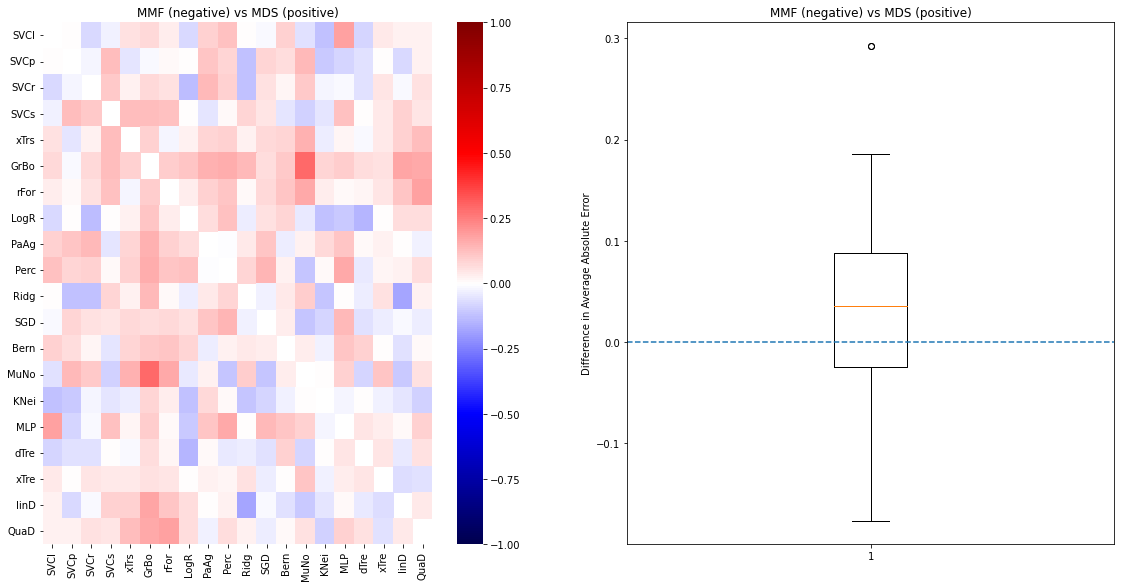

In [ ]:
actual = CompetitionResults(Curves)
algos = {'MMF (negative) vs MDS (positive)': [win.results['MMF']['binary'],win.results['MDS']['binary']]}
Compare(algos, actual, label = True)

### Windowing

In [ ]:
win = Windowing(aggCurves)
win.MDS()
win.MMF()

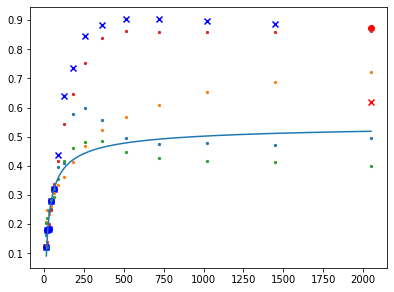

In [ ]:
win.scatter('SVCs', 4)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:130: RuntimeWarning: Mean of empty slice


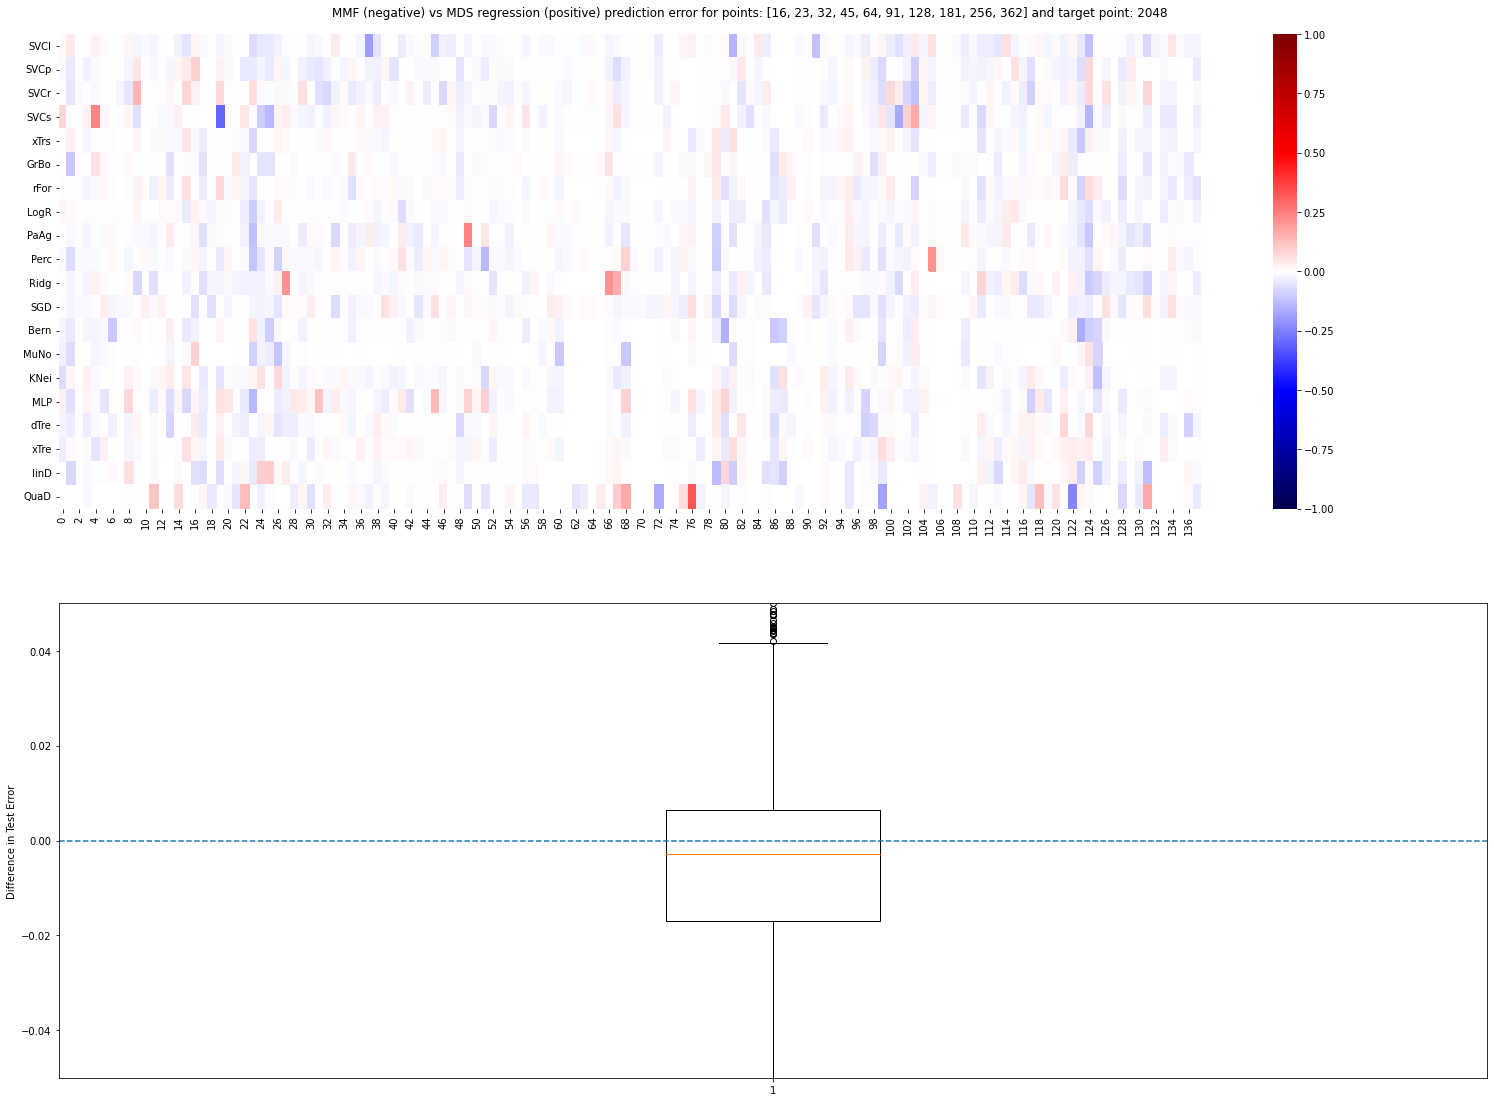

In [ ]:
win = Windowing(aggCurves, points = [16, 23, 32, 45, 64,91,128,181,256,362])
win.MMF(steps = 500)
win.MDS()
win.MMFvsMDS(ylim = (-0.05,0.05),min = -1, max = 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:117: RuntimeWarning: Mean of empty slice


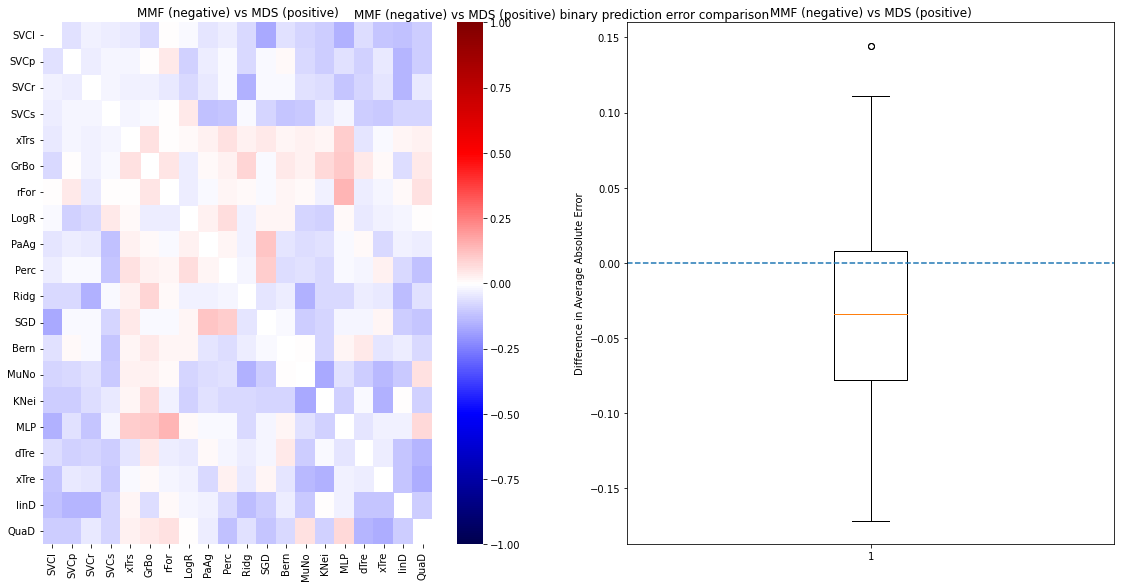

In [ ]:
Curves = RegularizeDF(aggCurves)
actual = CompetitionResults(Curves)
algos = {'MMF (negative) vs MDS (positive)': [win.results['MMF']['binary'],win.results['MDS']['binary']]}
Compare(algos, actual, label = True, title = 'MMF (negative) vs MDS (positive) binary prediction error comparison')

In [ ]:
# We try these methods in scipy.optimize.minimize (lm is what they use in paper and is for scipy.optimize.least_squares)
methods = ['default', 'Powell', 'lm','Nelder-Mead']
points = [16, 23, 32, 45, 64,91,128,181,256,362]
ptarget = [2048]
target_point = 2048
Curves = RegularizeDF(aggCurves,points+ptarget)
dataframe = Curves


testErrors = []
trainErrors = []
for method in methods:
  ans, penalty, success, params, trainError, testError = MMFbaseline(Curves, points, target_point, method)
  testErrors.append(testError)
  trainErrors.append(trainError)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:297: RuntimeWarning: overflow encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:297: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:297: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/scipy/optimize/_minimize.py:542: RuntimeWarning: Method Powell cannot handle constraints.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/_minimize.py:542: RuntimeWarning: Method Nelder-Mead cannot handle constraints.
  RuntimeWarning)


#### Checking if for a bigger window the tensorized version of MMF is still better

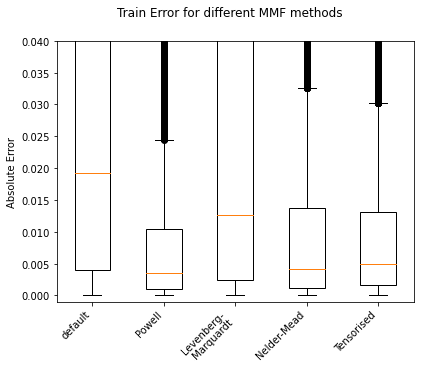

In [ ]:
# Powell vs default vs lm vs Nelder-Mead
default, Powell, lm, NM = np.array(trainErrors[0]),np.array(trainErrors[1]),np.array(trainErrors[2]),np.array(trainErrors[3])

#boxplot, looks like Powell is pretty good. Nelder-Mead is basically the same
#The default was pretty bad
plots = {'default': default, 'Powell': Powell, 'Levenberg-\n Marquardt': lm, 'Nelder-Mead': NM, 'Tensorised': win.results['MMF']['train error']}
Boxplots(plots, 'Absolute Error', ylim = (-0.001,0.04), xrot = True, title = 'Train Error for different MMF methods')

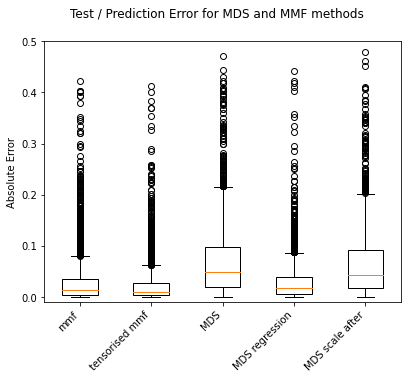

In [ ]:
plots = {'mmf': testError , 'tensorised mmf': win.results['MMF']['test error'], 'MDS': win.results['MDS']['test error'],'MDS regression': win.results['MDS regression']['test error'],'MDS scale after': win.results['MDS scale after']['test error']}
Boxplots(plots, 'Absolute Error', xrot = True, ylim = (-0.01,0.5), title = 'Test / Prediction Error for MDS and MMF methods')

### Plotting mmf model
Not as important but looks pretty

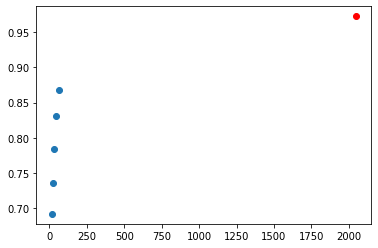

In [ ]:
# Do segment and target split
#91, 128, 181, 256
points = [16, 23, 32, 45, 64]
target_point = 2048
dataframe = aggCurves
learner_id = 0
dataset_id = 0


s = len(points)
points = np.array(points)
learners = dataframe['learner'].unique()
datasets = dataframe['openmlid'].unique()

# Get every segment and every target (for each learner in each dataset)
target = dataframe[dataframe['size_train'] == target_point]
segment = dataframe[dataframe['size_train'].isin(points)]

# To get an array that works nice with numpy (63,20,x) we need all 20 learners in each of the 63 datasets. Thus we can pad them in
multind = pd.MultiIndex.from_product([learners,points])
target = target.groupby(['openmlid']).apply(lambda grp: _add_missing(grp,'learner',learners)).reset_index().fillna(np.nan)
segment = segment.groupby(['openmlid']).apply(lambda grp: _add_missing(grp,['learner','size_train'],multind)).reset_index().fillna(np.nan)

# We end up with numpy array target and segment, the shape of segment is (63 dataset,20 learner,5 size_train for segment)
target = target['score_test'].values.reshape(-1,len(learners))
segment = segment['score_test'].values.reshape(-1,len(learners), s)


plt.scatter(points, segment[dataset_id,learner_id])
plt.scatter(ptarget, target[dataset_id,learner_id], color = 'red')


/usr/local/lib/python3.7/dist-packages/scipy/optimize/_minimize.py:542: RuntimeWarning: Method Powell cannot handle constraints.
  RuntimeWarning)


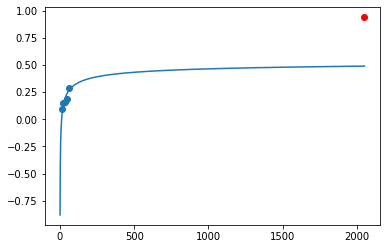

In [ ]:
#Plot for one curve

curve = segment[19,2]
s = len(points)
weights = 2**np.arange(s)
def mmf(beta):
  # Calculating loss of mmf model
  a, b, c, d = tuple(beta.astype(float))
  fun = lambda x: (a * b + c * x ** d)/(b + x ** d)
  penalties = weights * ((curve - fun(points))**2)
  penalties[np.isnan(penalties)] = 10**6
  return np.sum(penalties)

# No idea why this is here
factor = 1

# Constraint is that b*(c-a)*d > 0
const = {
    "type": "ineq", "fun": lambda x: -factor * x[1] * (x[2]-x[0])*x[3],
}

a, b, c, d = tuple(minimize(mmf, np.array([0.5,1,1,-1]), constraints=const, method = 'Powell').x)
fun = lambda x: (a * b + c * x ** d)/(b + x ** d)
x = np.linspace(1,2050,10000)
plt.plot(x,fun(x))
plt.scatter(points, segment[19,2])
plt.scatter(ptarget, target[19,2], color = 'red')

## MDS, simple and majority baseline

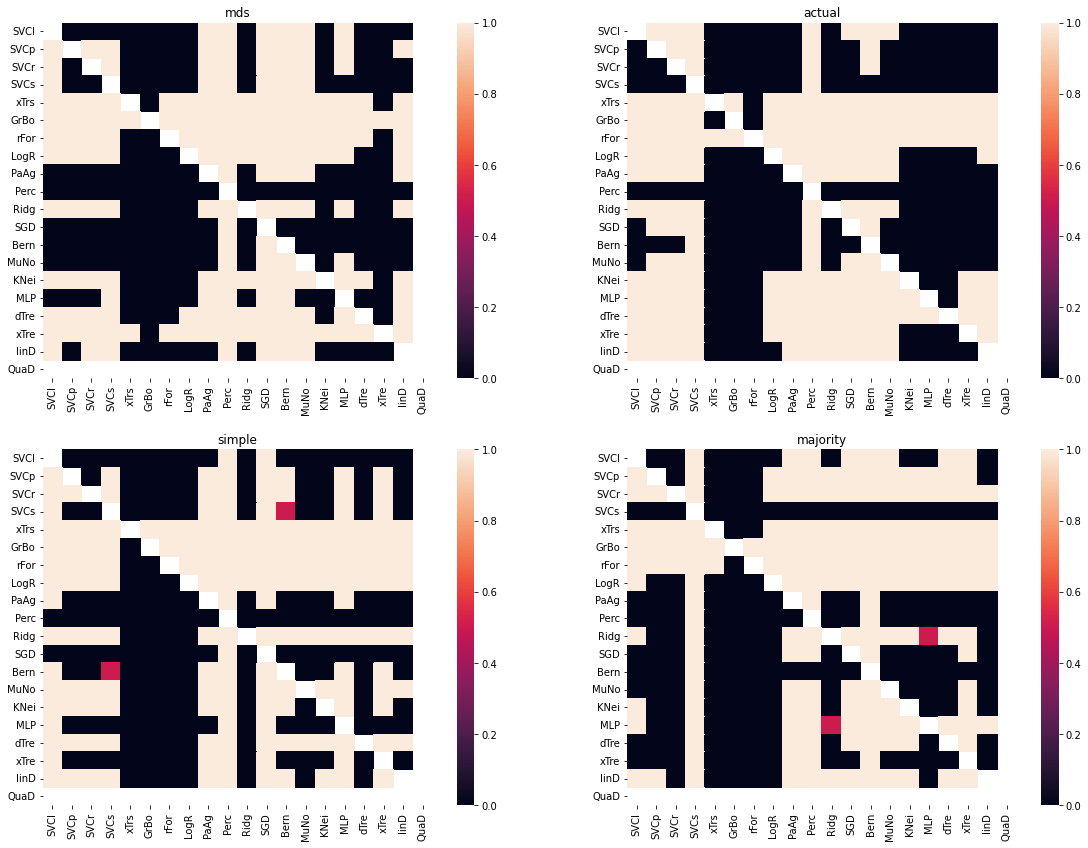

In [ ]:
Curves = RegularizeDF(aggCurves)

datasets = Curves['openmlid'].unique()

# Testing functions...
mdspred,_ = MDSCompetitionPredictions(Curves)
actual = CompetitionResults(Curves)
simple = SimpleCompetitionPredictions(Curves)
maj = MajorityClassCompetitionPredictions(actual)

maps = {'mds': mdspred[...,5],'actual': actual[...,5],'simple': simple[...,5], 'majority': maj[...,5]}
PlotHeatmap(maps, True)

# Cool graphs!, red is a tie

In [ ]:
# How about average wins (ignore error as it comes from 1v1 with yourself being empty)
aveMdspred = np.nanmean(mdspred,axis = -1)
aveActual = np.nanmean(actual, axis = -1)
aveSimple = np.nanmean(simple, axis = -1)
aveMaj = np.nanmean(maj, axis = -1)

maps = [aveMdspred,aveActual,aveSimple,aveMaj]
PlotHeatmap(maps)

# Looks like (on average) MDS is a lot better than the Simple algorithm

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


AttributeError: ignored

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys


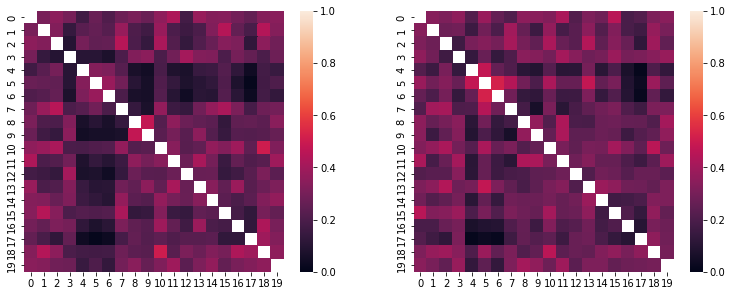

In [ ]:
# So how good are the predictions?
# We check by subtracting them from the actual values and then taking average
mdsdiff = np.abs(mdspred - actual)
simplediff = np.abs(simple - actual)

aveerrorMds = np.nanmean(mdsdiff, axis = -1)
aveerrorSimple = np.nanmean(simplediff, axis = -1)

PlotHeatmap([aveerrorMds,aveerrorSimple])

# On first glance it looks like MDS is slightly better than Simple
# We would like a very dark heat map though

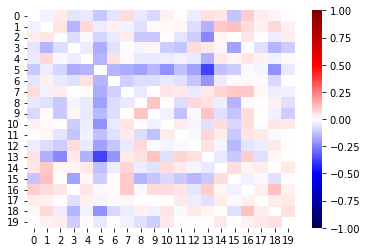

In [ ]:
# Take difference between them to check case by case which one is better
# Color map seismic to see better
test = aveerrorMds-aveerrorSimple
sns.heatmap(test, cmap = 'seismic', vmin = -1, vmax = 1)

# Red is where simple is better and blue where MDS is better

{'whiskers': [<matplotlib.lines.Line2D at 0x7f1e3036a550>,
 'caps': [<matplotlib.lines.Line2D at 0x7f1e30392d90>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f1e3036a450>],
 'medians': [<matplotlib.lines.Line2D at 0x7f1e3033fed0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f1e3033ff90>],
 'means': []}

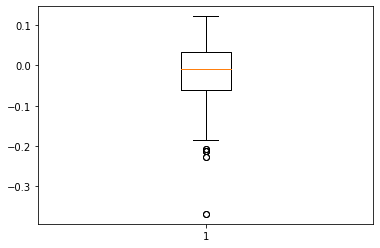

In [ ]:
# Boxplot to see how often one is better than the other
plt.boxplot(test[~np.isnan(test)].ravel())

# Negative means MDS is better, seems like they are very simmilarly dispersed but MDS is slightly better

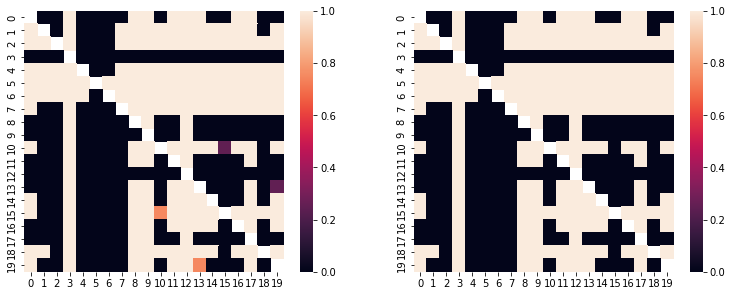

In [ ]:
# Majority Baseline, how close is it to just rounding across all the datasets
round = np.copy(aveActual)
round[round !=0.5] = np.round(round[round !=0.5] )

PlotHeatmap([aveMaj,round])

# Very close!

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


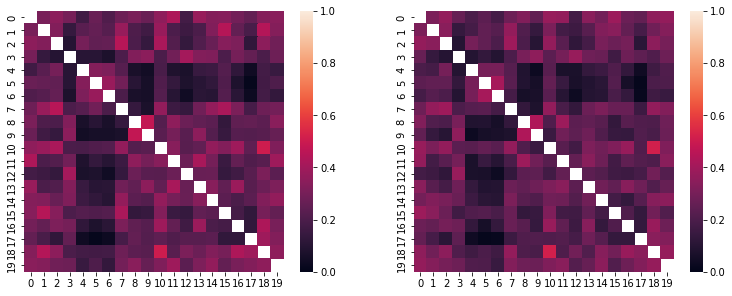

In [ ]:
# MDS before vs after
mdsafterpred = MDSscaleafter(Curves)
aveerrorMdsafter = np.nanmean(np.abs(mdsafterpred - actual), axis = -1)

PlotHeatmap([aveerrorMds,aveerrorMdsafter])

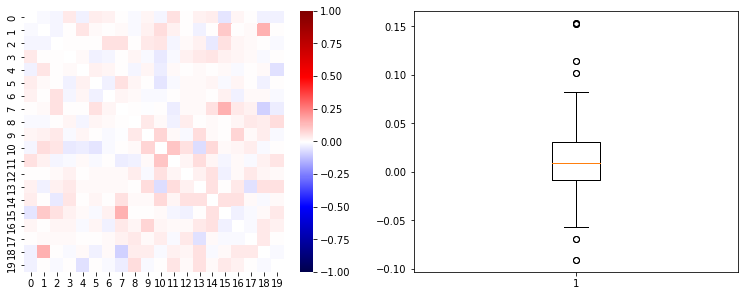

In [ ]:
test = aveerrorMds - aveerrorMdsafter
HeatmapBoxPlot(test)

# 3, Binary Decision Tree

Take as input maybe the following:
- first 5 points of curve for both learners
- what the learners are (random forest, neural network etc.)
- Point at which we want to predict which one is better
- Take difference of 5 points as input instead
- Take derivatives/momentum as input as well
- IPL/ MMF (better) model, lcdb paper shows which one is best

As we are not doing hyperparameter tuning (or any other preprocessing) it is not necesarry to do a train-test-validation split.
Also, we want to see the predictions on each dataset and not an accuracy so that we can compare it to MDS (previous section). To do this my idea is to do something similar to a 5-fold cross-validation, however, we take the values from the "test" fold. In the end we will have trained the classifier 5 times each time with a different combination of 4 out of the 5 folds and then we take the values of the remaining fold.

As input we take the 5 anchor points ([16, 23, 32, 45, 64]). The output will be taken as the winner at $s_{ref}=2048$.

Next step?
- Train, test, VALIDATION

Right now we do not split train, test validation when comparing different configurations of the binary decision tree (different inputs). Maybe leave some datasets out for test score? Answer = no don't. Research methods like this there will always be some sort of bias since you are in direct contact with the dataset. Better to do it like this now and then after try it on the bigger dataset.

- Take as input point at which we want to predict which one is better? Maybe something for later, but right now not so important

- Ensemble or boost method? Random forest

In [ ]:
def mmf(beta):
    a, b, c, d = tuple(beta.astype(float))
    fun = lambda x: (a * b + c * x ** d)/(b + x ** d)
    penalties = []
    for i, size in enumerate(sizes):
        penalty = weights[i]  * ((scores[i] - fun(size)) ** 2) # give more weights on higher anchors
        penalties.append(penalty if not np.isnan(penalty) else 10**6)
    return sum(penalties)

In [ ]:
weights = 2**np.arange(len(points))

def mmf(beta):
    a, b, c, d = tuple(beta.astype(float))
    fun = lambda x: (a * b + c * x ** d)/(b + x ** d)
    penalties = weights*((segment - fun(points))**2)
    penalties[np.isnan(penalties)] = 10**6
    return np.sum(penalties)

factor = 1

const = {
    "type": "ineq", "fun": lambda x: -factor * x[1] * (x[2]-x[0])*x[3],
}
a, b, c, d = tuple(scipy.optimize.minimize(mmf, np.array([0.5,1,1,-1]), constraints=const).x)
return (a, b, c, d), lambda x: (a * b + c * x ** d)/(b + x ** d)

ans = weights*(segment - points)
ans.shape

(138, 20, 5)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneOut

def Segment(dataframe, points=[16, 23, 32, 45, 64], target = 2048):
    '''
    Takes the relevant anchor points from the dataframe and puts it into a numpy array.
    Padding of missing learners will also happen (padded as np.nan).

    Again this requires the dataframe to be regularized (every learner has the given points and taget)
    '''    
    s = len(points)
    learners = dataframe['learner'].unique()
    datasets = dataframe['openmlid'].unique()
    
    # Get every segment and every target (for each learner in each dataset)
    target = dataframe[dataframe['size_train'] == target]
    segment = dataframe[dataframe['size_train'].isin(points)]

    # To get an array that works nice with numpy (63,20,x) we need all 20 learners in each of the 63 datasets. Thus we can pad them in
    multind = pd.MultiIndex.from_product([learners,points])
    target = target.groupby(['openmlid']).apply(lambda grp: _add_missing(grp,'learner',learners)).reset_index().fillna(np.nan)
    segment = segment.groupby(['openmlid']).apply(lambda grp: _add_missing(grp,['learner','size_train'],multind)).reset_index().fillna(np.nan)

    # We end up with numpy array target and segment, the shape of segment is (63 dataset,20 learner,5 size_train for segment)
    target = target['score_test'].values.reshape(-1,len(learners))
    segment = segment['score_test'].values.reshape(len(datasets),len(learners), -1)

    return segment,target

def Preprocessing(dataframe, args, points=[16, 23, 32, 45, 64], target = 2048):
    '''
    Takes the relevant data from the dataframe and puts it into a numpy array.
    Padding of missing learners will also happen (padded as np.nan).
    If leatner_as_festure is true it will take the anchor point values and the label
    encoded learner as input features. Otherwise it just takes the anchor point values.

    Again this requires the dataframe to be regularized (every learner has the given points and taget)
    '''
    s = len(points)
    points = np.array(points)
    learners = dataframe['learner'].unique()
    datasets = dataframe['openmlid'].unique()

    segment,target = Segment(dataframe, points, target)
    
    # Initialise array of features
    X = np.full((len(datasets),len(learners),len(learners), 0),np.nan)
    
    # We don't check for ties as we want to know if l1 is strictly better than l2
    y = target[:,:,np.newaxis] > target[:,np.newaxis]

    if 'learner' in args:
      # What learner, represented by a number (0 -> 19)
      label = np.indices(target.shape[:2])[1][...,np.newaxis]
      label = np.concatenate(np.broadcast_arrays(label[:,:,np.newaxis],label[:,np.newaxis]),axis = -1)
      X = np.append(X,label, axis = -1)
    
    if 'raw' in args:
      # We want all combinations of learners in their respective dataset
      # thus broadcast into concatenate. This will give array (i,j,k,l) where the last axis
      # contains the 5 segment points of learner j and then the 5 segment points of learner k (in dataset i)
      raw = np.concatenate(np.broadcast_arrays(segment[:,:,np.newaxis],segment[:,np.newaxis]),axis = -1)
      X = np.append(X,raw, axis = -1)
    
    if 'simple' in args:
      # Difference of the anchor points, meant to steer towards last1 model
      diff = segment[:,:,np.newaxis]-segment[:,np.newaxis]
      X = np.append(X,diff, axis = -1)
    
    if 'pow2' in args:
      # Not useful
      # assume y = -a * x ^ -b, y is the anchor point value and x the anchor point
      # take all log(y_i / y_j) / log(x_i / x_j)
      divseg = segment[...,np.newaxis]/segment[:,:,np.newaxis]
      divpoints = points[...,np.newaxis]/points[np.newaxis,:]

      # Don't divide by yourself
      np.einsum('...kk->...k',divseg)[...] = np.nan
      np.einsum('...kk->...k',divpoints)[...] = np.nan

      # Average them, this is now the approximation of -b
      power = np.log(divseg)/np.log(divpoints)[np.newaxis,np.newaxis]
      power = np.nanmean(power,axis = (-1,-2))

      # multiply by x^-b to get y = -a, so it is supposed to be constant
      mult = segment*(points[np.newaxis,np.newaxis,:]**power[...,np.newaxis])
      # We take the difference again
      X = np.append(X,mult[:,:,np.newaxis]-mult[:,np.newaxis], axis = -1)
    
    if '1storder' in args:
      diff = np.diff(segment, 1, axis =-1)
      diff = np.concatenate(np.broadcast_arrays(diff[:,:,np.newaxis],diff[:,np.newaxis]),axis = -1)
      X = np.append(X,diff, axis = -1)
    
    if '2ndorder' in args:
      diff = np.diff(segment, 2, axis =-1)
      diff = np.concatenate(np.broadcast_arrays(diff[:,:,np.newaxis],diff[:,np.newaxis]),axis = -1)
      X = np.append(X,diff, axis = -1)
    
    if '3rdorder' in args:
      diff = np.diff(segment, 3, axis =-1)
      diff = np.concatenate(np.broadcast_arrays(diff[:,:,np.newaxis],diff[:,np.newaxis]),axis = -1)
      X = np.append(X,diff, axis = -1)

    if 'MDS' in args:
      knn_target = MDSpick(segment.swapaxes(0,1), target.T)[...,np.newaxis]
      knn_target = np.einsum('ijk...->kij...',knn_target)[...]
      Tknn_target = np.einsum('ijk...->ikj...',knn_target)[...]
      X = np.append(X,knn_target, axis = -1)
      X = np.append(X,Tknn_target, axis = -1)

    # Don't compete against yourself
    np.einsum('ijj...->ij...',X)[...] = np.nan
    np.einsum('ijj...->ij...',y)[...] = np.nan

    return X,y

def Binary_tree(X,y, forest = False):
    '''
    Construct the binary tree or random forest with the given data (X input, y output).
    Both use default parameters in sklearn.
    '''
    if forest:
      clf = RandomForestClassifier()
    else:
      clf = DecisionTreeClassifier()
    
    clf.fit(X,y)
    return clf

def Leave_one_out(dataframe, args, points=[16, 23, 32, 45, 64], target = 2048, forest = False):
    '''
    Perform leave one out test for each dataset. We train on the given train datasets
    and then predict on the left out dataset which we take as the result for that dataset.
    We do this for every dataset to get a prediction of the entire dataframe

    Again this requires the dataframe to be regularized (every learner has the given points and taget)
    '''
    X,y = Preprocessing(dataframe, args, points, target)
    loo = LeaveOneOut()
    print(X.shape)
    res = []
    # For loop as we use sklearn
    for train_index, test_index in loo.split(X):

      #First we take out the dataset then we reshape to get the shape (nsamples,nfeatures)
      X_train, X_test = X[train_index].reshape(-1,X.shape[-1]), X[test_index].reshape(-1,X.shape[-1])
      y_train = y[train_index].reshape(-1)

      # sklearn doesn't like np.nan so we take out each sample that has any np.nan
      ind1 = ~np.isnan(np.sum(X_train,axis=-1))
      ind2 = ~np.isnan(np.sum(X_test,axis=-1))
      X_train,X_test = X_train[ind1], X_test[ind2]
      y_train = y_train[ind1]
      y_test = np.full(y.shape[1]**2,np.nan)

      # Fit tree then predict
      clf = Binary_tree(X_train,y_train, forest)
      y_test[ind2] = clf.predict(X_test)
      res.append(y_test)
    
    return np.array(res).reshape(y.shape)

def MDSpick(segment, target, k=4):
    '''
    We use the MDS scale after to pick the scaled scaled targets.
    Scale vefore seems to be a little worse that is why.
    '''
    s = segment.shape[-1]
    print(s)
    weights = np.arange(1, s + 1) ** 2
    scalar = np.sum(weights * segment[:,:,np.newaxis] * segment[:, np.newaxis],axis=-1)/np.sum(weights * (segment ** 2), axis=-1)[:,np.newaxis]


    pairs = scalar[...,np.newaxis]*segment[:,np.newaxis]
    scaled_target = scalar * target[:,np.newaxis]

    distance = np.sum((segment[:,:,np.newaxis] - segment[:,np.newaxis]) ** 2, axis = -1)

    np.einsum('ijj->ij', distance)[...] = np.nan
    distancesum = distance[:,np.newaxis] + distance

    k_index = np.argpartition(distancesum, k, axis = -1)[...,:k]
    knn_scaled_targets =  np.mean(np.array([np.take_along_axis(scaled_target,k_index[i],axis=-1) for i in range(scaled_target.shape[0])]),axis=-1)
    return knn_scaled_targets


## Experimentation ($s_{ref} = 2048$)

In [ ]:
Curves = RegularizeDF(aggCurves)

# For loop, so takes about a minute per algo
#dt_raw = Leave_one_out(Curves,['raw'])
dt_l_raw = Leave_one_out(Curves, ['learner','raw'])
dt_l_simple = Leave_one_out(Curves, ['learner','simple'])
dt_l_raw_1storder = Leave_one_out(Curves, ['learner','raw','1storder'])
dt_l_raw_12order = Leave_one_out(Curves, ['learner','raw','1storder','2ndorder'])
dt_l_raw_123order = Leave_one_out(Curves, ['learner','raw','1storder','2ndorder','3rdorder'])

# Reshape to work with this better, also round as we don't take ties anymore
actual2 = np.einsum('ijk->kij',np.round(actual))

NameError: ignored

In [ ]:
def Compare(alg1,alg2):
    erralg1 = np.nanmean(np.abs(alg1 - actual2),axis = 0)
    erralg2 = np.nanmean(np.abs(alg2 - actual2),axis = 0)
    test = erralg1 - erralg2
    HeatmapBoxPlot(test)

def CompareMDS(alg1):
    erralg1 = np.nanmean(np.abs(alg1 - actual2),axis = 0)
    test = erralg1 - aveerrorMds
    HeatmapBoxPlot(test)

In [ ]:
dt_l_raw_MDS = Leave_one_out(Curves, ['learner','raw','MDS'])
dt_l_MDS = Leave_one_out(Curves, ['learner','MDS'])

5
(138, 20, 20, 14)
5
(138, 20, 20, 4)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


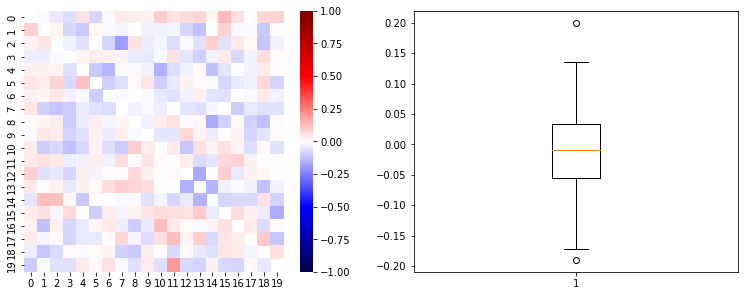

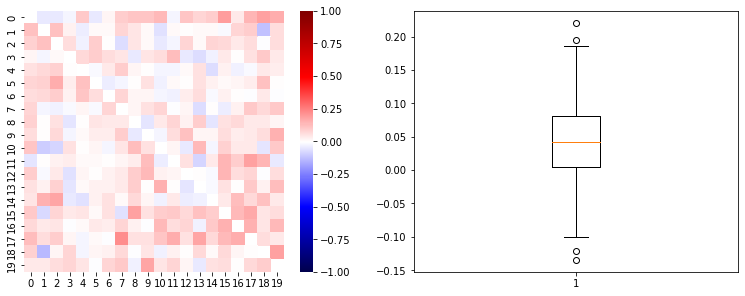

In [ ]:
Compare(dt_l_raw_MDS,dt_l_MDS)
CompareMDS(dt_l_raw_MDS)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


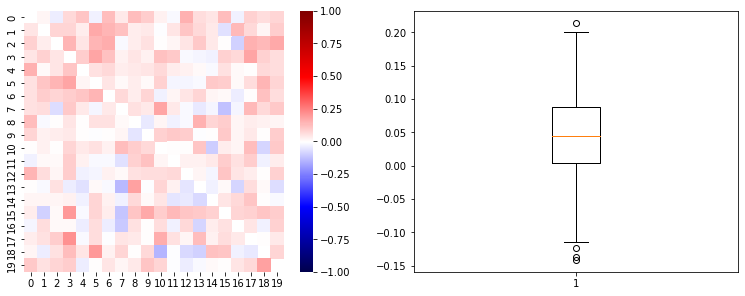

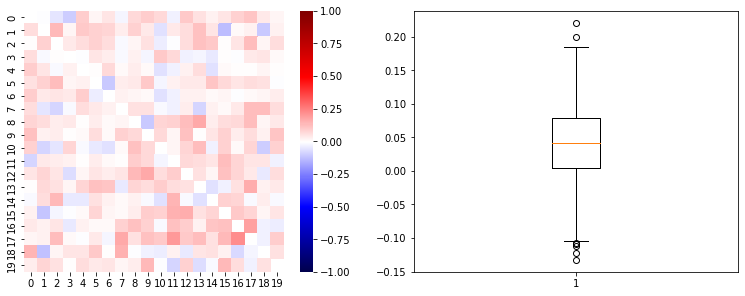

In [ ]:
CompareMDS(dt_l_simple)
CompareMDS(dt_l_raw)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


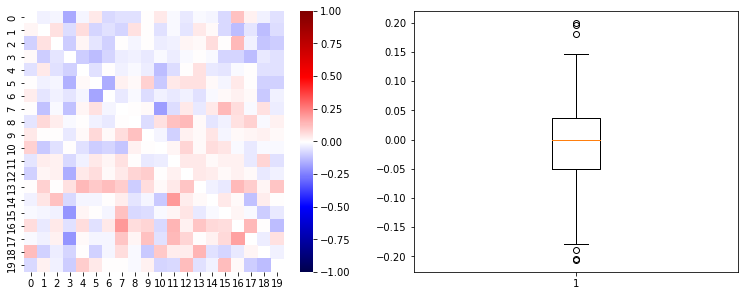

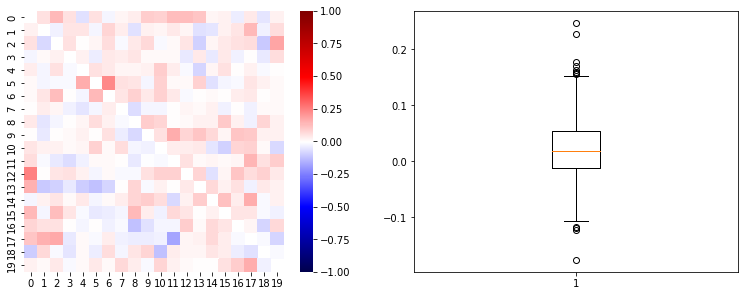

In [ ]:
Compare(dt_l_raw,dt_l_simple)
Compare(dt_l_raw_123order,dt_l_raw)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


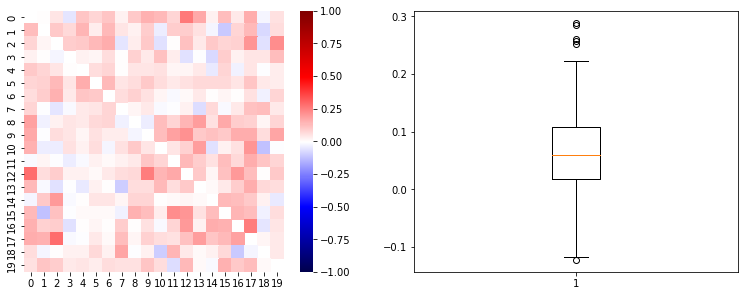

In [ ]:
CompareMDS(dt_l_raw_123order)

## Forest

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


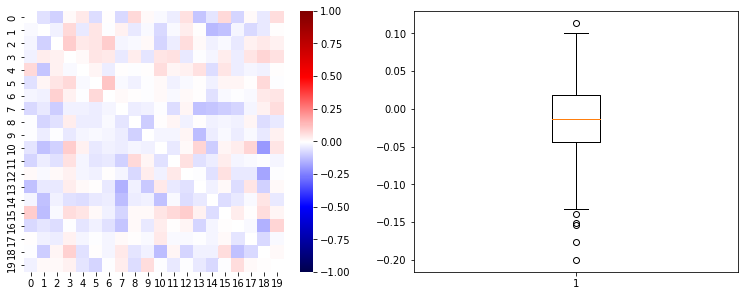

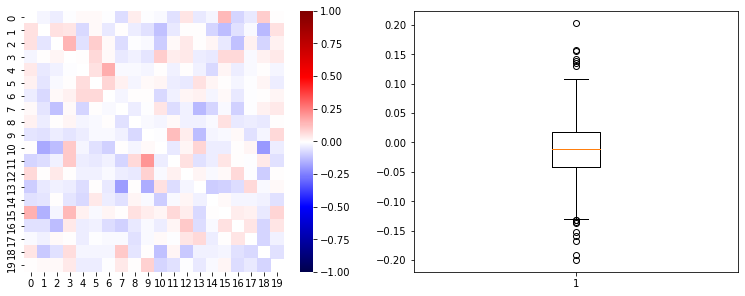

In [ ]:
# Lets try forest
forest_l_simple = Leave_one_out(Curves, ['learner','simple'], forest=True)
forest_l_raw_123order = Leave_one_out(Curves, ['learner','raw','1storder','2ndorder','3rdorder'], forest=True)

CompareMDS(forest_l_simple)
CompareMDS(forest_l_raw_123order)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


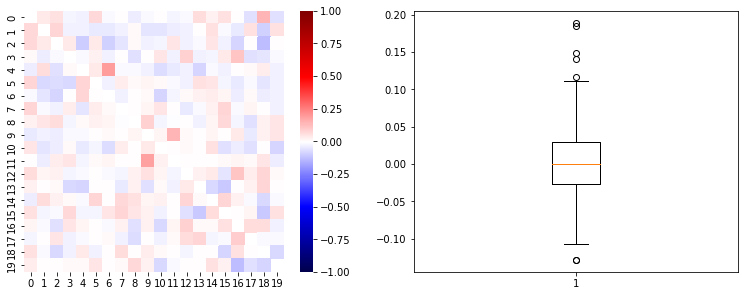

In [ ]:
Compare(forest_l_raw_123order,forest_l_simple)

# 4, Problem Setting.
What window do we need for what algorithms to make a nice prediction. With what windows are what algorithms better.